In [1]:
from PIL import Image
import h5py
import anubisPlotUtils as anPlot
import json
import numpy as np
import os
import hist as hi
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
matplotlib.use('TkAgg')  # or 'Qt5Agg', 'GTK3Agg', etc.
import mplhep as hep
hep.style.use([hep.style.ATLAS])
import sys
import ANUBIS_triggered_functions as ANT
import pandas as pd
import matplotlib.backends.backend_pdf
from matplotlib.ticker import MultipleLocator
import plotly
import plotly.graph_objs as go
import plotly.express as px
import csv

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm


%matplotlib inline

In [2]:
current_directory=  os.path.dirname(os.getcwd())

data = ANT.importDatafile(current_directory+"\\ProAnubisData\\ATLAS LUMINOSITY\\proAnubis_240403_0227.h5")

In [3]:
data_ATLAS = [sublist[:94230] for sublist in data]
etaHits, phiHits = ANT.divideHitCountsByRPC_Timed(data_ATLAS)

In [4]:
#Time_window for coincidence set at 15 ns.
#Temporal Clustering
coincident_hits_ATLAS = ANT.FindCoincidentHits(etaHits,phiHits,15)

#Spatial Clustering
coincident_hits_ATLAS_clustered = ANT.cluster(coincident_hits_ATLAS)

0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0

In [22]:
def reconstruct_timed_Chi2_ByRPC(event,max_cluster_size, RPC_excluded):

    #timed tag indicates that timing information from RPC is used to determine direction of vertical transversal of "particle" in the event.

    max_Chi2 = 10

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]
    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.


    #Extract x and y coords of cluster in event
    coords = ANT.extract_coords_timed_Chi2(event,max_cluster_size)

     # Filter out coords of RPC under test 

    test_coords = coords[RPC_excluded]

    coords[RPC_excluded] = [[],[],"N"] 

    # Count the number of empty RPCs
    empty_RPC_count = sum(1 for item in coords if item == [[], [],'N'])

    # If less than 3 elements of coords are occupied, exit the function
    if empty_RPC_count > 3:
        #print("Failed to reconstruct, not enough coords")
        return None  # Exit the function
    
    cross_chamberness = 0

    if coords[0] != [[], [], 'N'] or coords[1] != [[], [], 'N'] or coords[2] != [[], [], 'N']:
        cross_chamberness += 1

    if coords[3] != [[], [], 'N']:
        cross_chamberness += 1

    if coords[4] != [[], [], 'N'] or coords[5] != [[], [], 'N']:
        cross_chamberness += 1

    if cross_chamberness < 2:
        #print("Failed to reconstruct, too few chambers")
        return None

    #ITERATING OVER EVERY POSSIBLE COMBINATION OF x,y,z over all 3 RPCs (limited to one x,y per RPC).
    #Doesn't look particularly nice, but there are not many coordinates to loop over usually....

    combinations = ANT.generate_hit_coords_combo_Chi2(coords,RPC_heights)

    #Now for each combo in combinations, attempt to reconstruct a path. See which one gives the best trajectory.

    #If success, print parameters of fitting function.
    #If fail, print reconstruction failed.

    Chi2_current = np.inf
    optimised_coords = None
    optimised_d= None
    optimised_centroid= None
    dT = [np.inf,np.inf]

    for ind,combo in enumerate(combinations):

        centroid, d, Chi2, coordinates, delta_T, delta_Z= ANT.fit_event_chi2(combo)
        if Chi2 < Chi2_current:

            # If new fit is better than old then replace old fit properties.
            dZ = delta_Z 
            dT = delta_T
            Chi2_current = Chi2
            optimised_centroid = centroid
            optimised_d = d
            optimised_coords = coordinates

    #if dT>0 this implies the particles hit the higher RPC after the lower one, so the particle is travelling upwards here.
    #Vice-versa for dT < 0.

    #dT = 0 case?

    if dT[0] != np.inf:

        if dT[0] > 0:
            if optimised_d[2] < 0:
                optimised_d = np.multiply(optimised_d,-1)
        else:
            if optimised_d[2] > 0:
                optimised_d = np.multiply(optimised_d,-1)

        if Chi2_current<max_Chi2:
            return optimised_centroid, optimised_d, optimised_coords, combinations, Chi2_current, dT, dZ, test_coords

    else:
        #print("Failed to reconstruct, Chi2 too large")
        #return optimised_centroid, optimised_d, optimised_coords, combinations, residuals_current
        return None
    
def calc_efficiency_RPC(dataset,RPC,tol):
    # RPC input is number 0 to 5.
    # dataset is output of ANT.cluser()
    # tol is tolerance on checkHit in cm.

    events = ANT.filter_events_by_RPC(dataset,2,5,RPC)

    possible_reconstructions = 0
    successful_reconstructions = 0

    for i,event in enumerate(events):

        #print(f"Event index {i}")

        E_recon = reconstruct_timed_Chi2_ByRPC(event,3,RPC)

        if E_recon:

            if len(E_recon[2])>=5:
                #Adding this check to see if other 5 RPCs are in reconstructed event.
                #This is necessary to ensure the reconstructed path is accurate.

                muon_coords = ANT.does_muon_hit_RPC(E_recon[0],E_recon[1],RPC)

                if muon_coords:

                    possible_reconstructions+=1 

                    check = does_RPC_detect_muon(muon_coords,E_recon[7],tol)

                    if check:
                        successful_reconstructions+=1 

    print(possible_reconstructions)
    print(successful_reconstructions)

    return successful_reconstructions/possible_reconstructions

def does_RPC_detect_muon(muon_coords,test_coords,tol):
    #Tolerance in units of cm. 

    #Could experiment with tolerance.

    if test_coords != [[],[],"N"]: 

        x_coords = test_coords[0]
        y_coords = test_coords[1]

        for x_set in x_coords:
            for y_set in y_coords:

                x = x_set[0]
                y = y_set[0]
    
                #If statement ensures only calculate the coords if the test_coords actually exist.

                #Offset is 2D vector that represents difference 
                offset = np.subtract(np.array([x,y]),muon_coords)

                separation = np.linalg.norm(offset)

                #print(separation)

                if separation <= tol:
                    #Say the RPC only successfully reconstructs an event 
                    #if the distance between expected hit and reconstructed hit is less than tolerance.

                    #print("RPC successfully detects hit!")
                    return separation
        
        #print("No RPC coordinates constructed pass near the expected point!")
        return False

    else:
        #print("No coordinates reconstructed by RPC")
        return False

0.0
999
0
0.40816326530612246
999
173
0.8163265306122449
999
350
1.2244897959183674
999
493
1.6326530612244898
999
609
2.0408163265306123
999
680
2.4489795918367347
999
708
2.857142857142857
999
722
3.2653061224489797
999
725
3.673469387755102
999
725
4.081632653061225
999
725
4.4897959183673475
999
725
4.8979591836734695
999
725
5.3061224489795915
999
725
5.714285714285714
999
725
6.122448979591837
999
725
6.530612244897959
999
725
6.938775510204081
999
725
7.346938775510204
999
725
7.755102040816327
999
725
8.16326530612245
999
725
8.571428571428571
999
725
8.979591836734695
999
725
9.387755102040817
999
725
9.795918367346939
999
725
10.204081632653061
999
725
10.612244897959183
999
725
11.020408163265307
999
725
11.428571428571429
999
725
11.83673469387755
999
725
12.244897959183675
999
725
12.653061224489797
999
725
13.061224489795919
999
725
13.46938775510204
999
725
13.877551020408163
999
725
14.285714285714286
999
725
14.693877551020408
999
725
15.10204081632653
999
725
15.51020

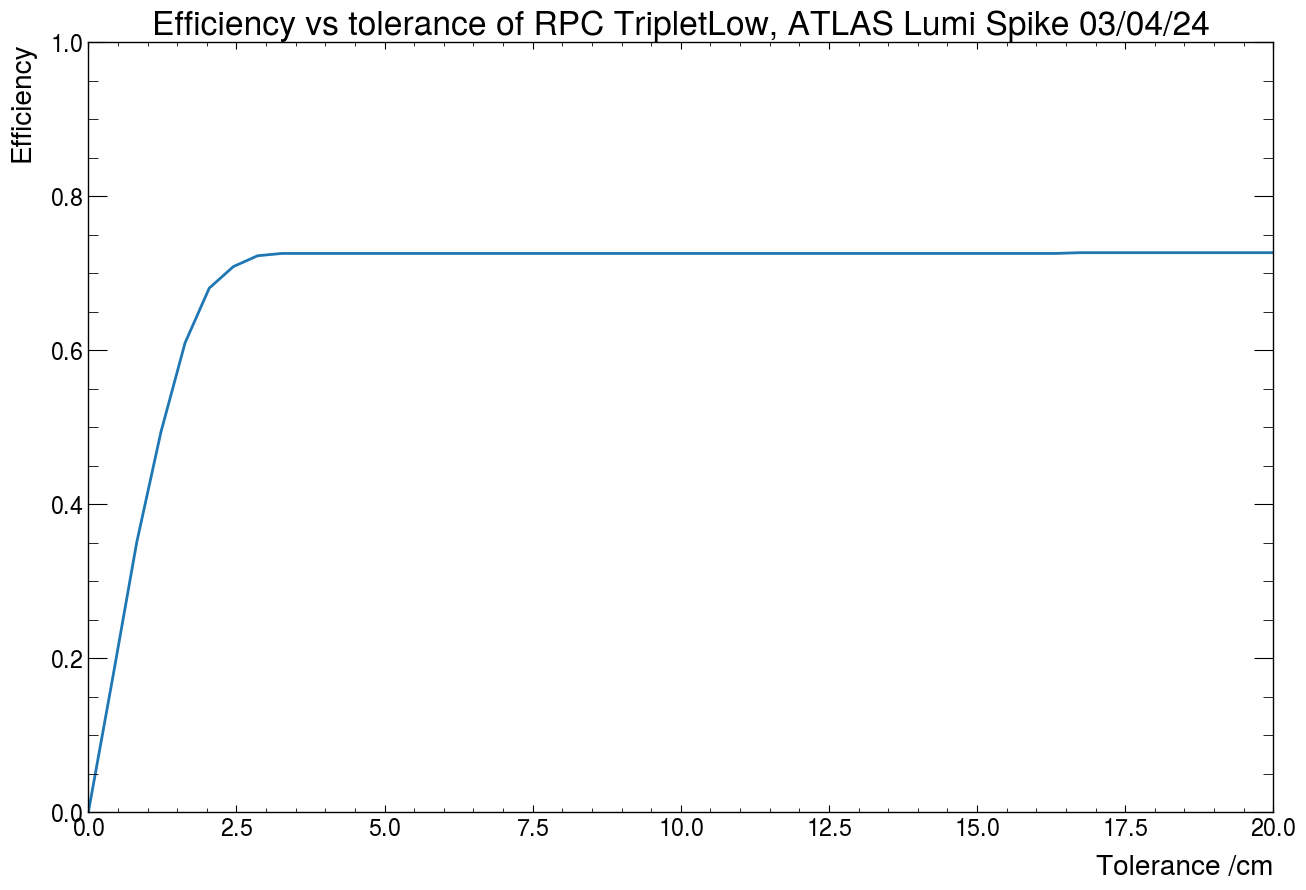

0.0
884
0
0.40816326530612246
884
115
0.8163265306122449
884
266
1.2244897959183674
884
414
1.6326530612244898
884
544
2.0408163265306123
884
624
2.4489795918367347
884
684
2.857142857142857
884
710
3.2653061224489797
884
720
3.673469387755102
884
729
4.081632653061225
884
729
4.4897959183673475
884
729
4.8979591836734695
884
729
5.3061224489795915
884
729
5.714285714285714
884
729
6.122448979591837
884
729
6.530612244897959
884
729
6.938775510204081
884
729
7.346938775510204
884
729
7.755102040816327
884
729
8.16326530612245
884
729
8.571428571428571
884
729
8.979591836734695
884
729
9.387755102040817
884
729
9.795918367346939
884
729
10.204081632653061
884
729
10.612244897959183
884
729
11.020408163265307
884
729
11.428571428571429
884
729
11.83673469387755
884
729
12.244897959183675
884
729
12.653061224489797
884
729
13.061224489795919
884
729
13.46938775510204
884
729
13.877551020408163
884
729
14.285714285714286
884
729
14.693877551020408
884
729
15.10204081632653
884
729
15.51020

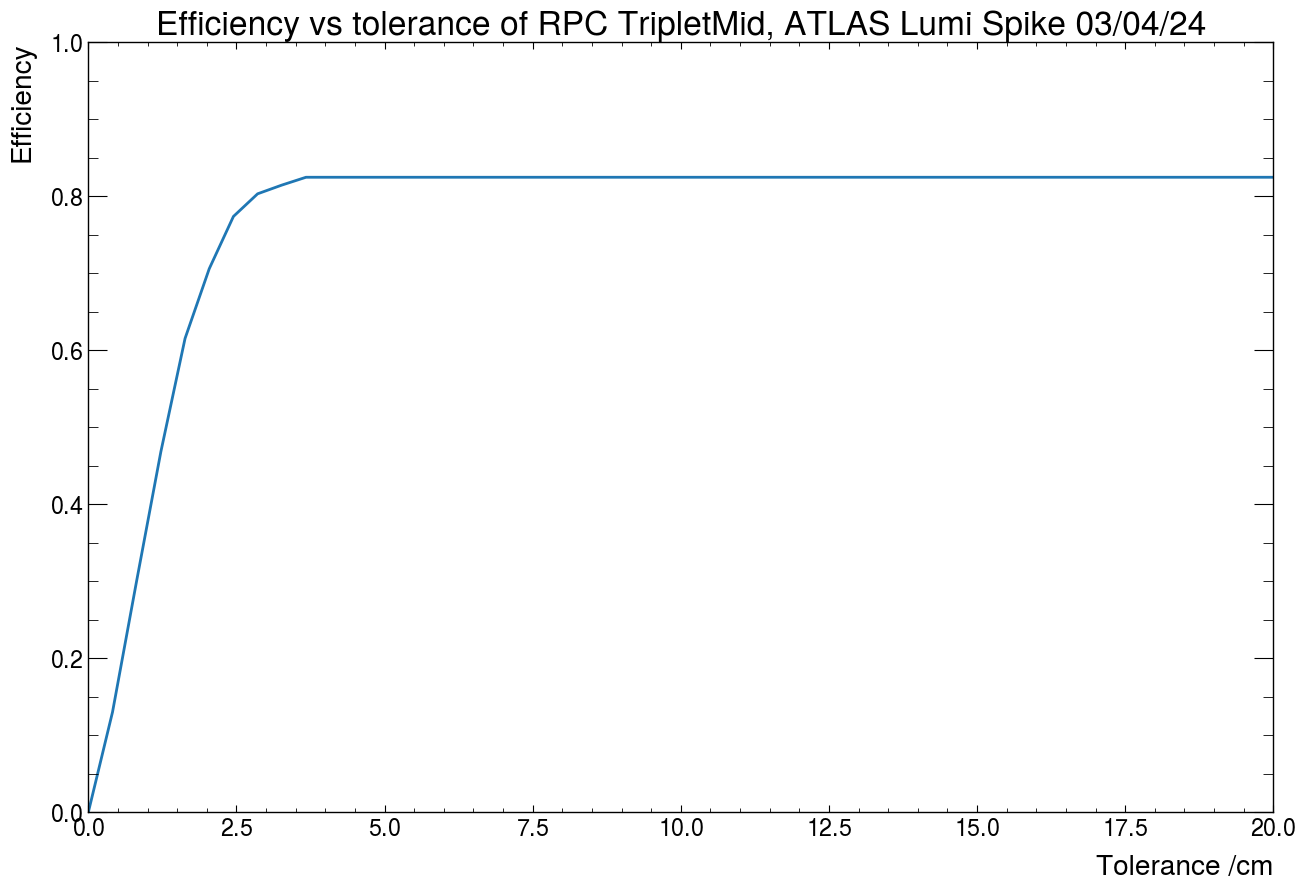

0.0
1031
0
0.40816326530612246
1031
71
0.8163265306122449
1031
306
1.2244897959183674
1031
505
1.6326530612244898
1031
608
2.0408163265306123
1031
669
2.4489795918367347
1031
708
2.857142857142857
1031
716
3.2653061224489797
1031
723
3.673469387755102
1031
723
4.081632653061225
1031
727
4.4897959183673475
1031
727
4.8979591836734695
1031
727
5.3061224489795915
1031
728
5.714285714285714
1031
728
6.122448979591837
1031
728
6.530612244897959
1031
728
6.938775510204081
1031
728
7.346938775510204
1031
728
7.755102040816327
1031
728
8.16326530612245
1031
728
8.571428571428571
1031
728
8.979591836734695
1031
728
9.387755102040817
1031
728
9.795918367346939
1031
728
10.204081632653061
1031
728
10.612244897959183
1031
728
11.020408163265307
1031
728
11.428571428571429
1031
728
11.83673469387755
1031
729
12.244897959183675
1031
729
12.653061224489797
1031
730
13.061224489795919
1031
730
13.46938775510204
1031
730
13.877551020408163
1031
730
14.285714285714286
1031
730
14.693877551020408
1031
73

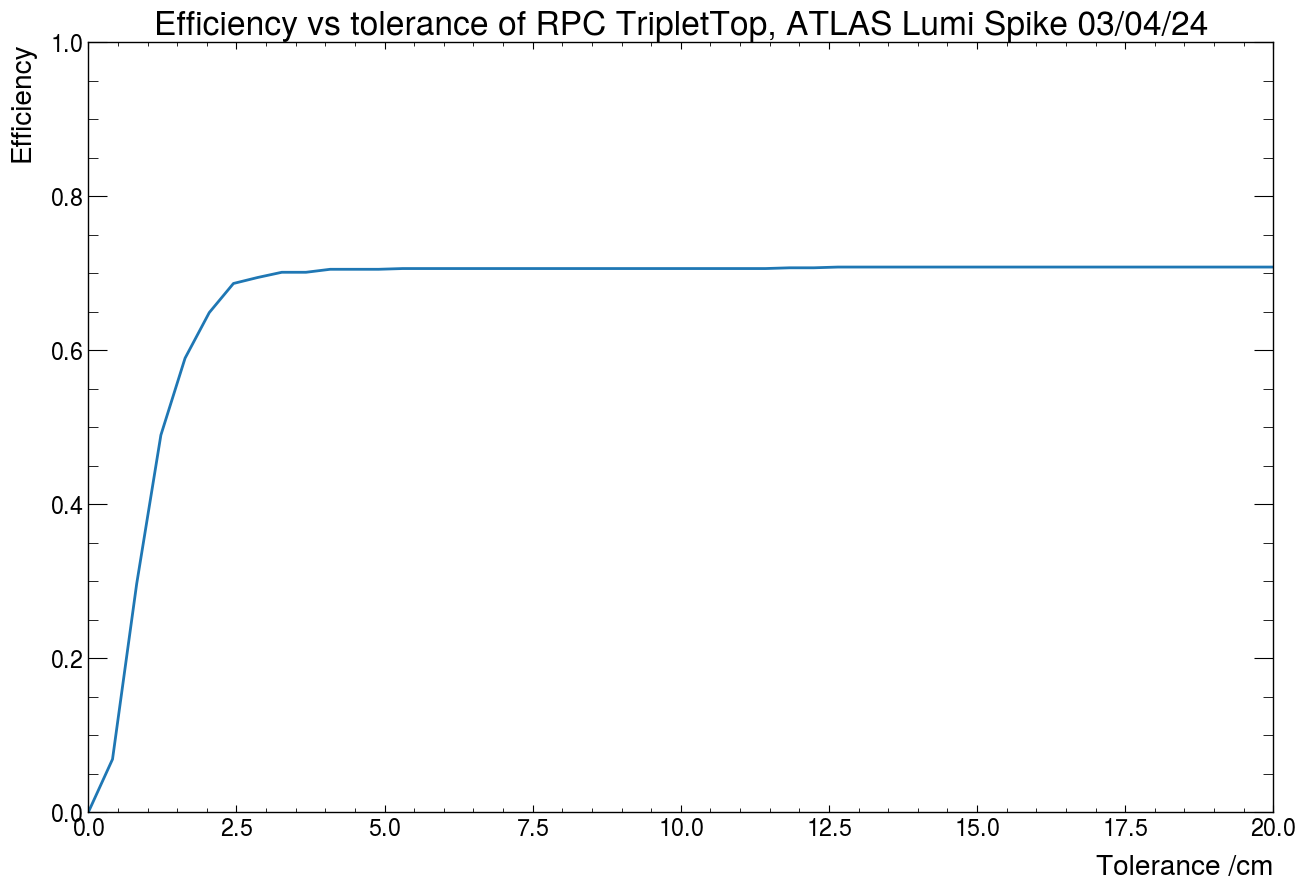

0.0
1055
0
0.40816326530612246
1055
30
0.8163265306122449
1055
67
1.2244897959183674
1055
135
1.6326530612244898
1055
251
2.0408163265306123
1055
358
2.4489795918367347
1055
461
2.857142857142857
1055
542
3.2653061224489797
1055
610
3.673469387755102
1055
644
4.081632653061225
1055
671
4.4897959183673475
1055
691
4.8979591836734695
1055
711
5.3061224489795915
1055
719
5.714285714285714
1055
726
6.122448979591837
1055
731
6.530612244897959
1055
733
6.938775510204081
1055
733
7.346938775510204
1055
735
7.755102040816327
1055
737
8.16326530612245
1055
738
8.571428571428571
1055
740
8.979591836734695
1055
740
9.387755102040817
1055
741
9.795918367346939
1055
745
10.204081632653061
1055
750
10.612244897959183
1055
751
11.020408163265307
1055
752
11.428571428571429
1055
752
11.83673469387755
1055
752
12.244897959183675
1055
753
12.653061224489797
1055
755
13.061224489795919
1055
756
13.46938775510204
1055
758
13.877551020408163
1055
759
14.285714285714286
1055
759
14.693877551020408
1055
759

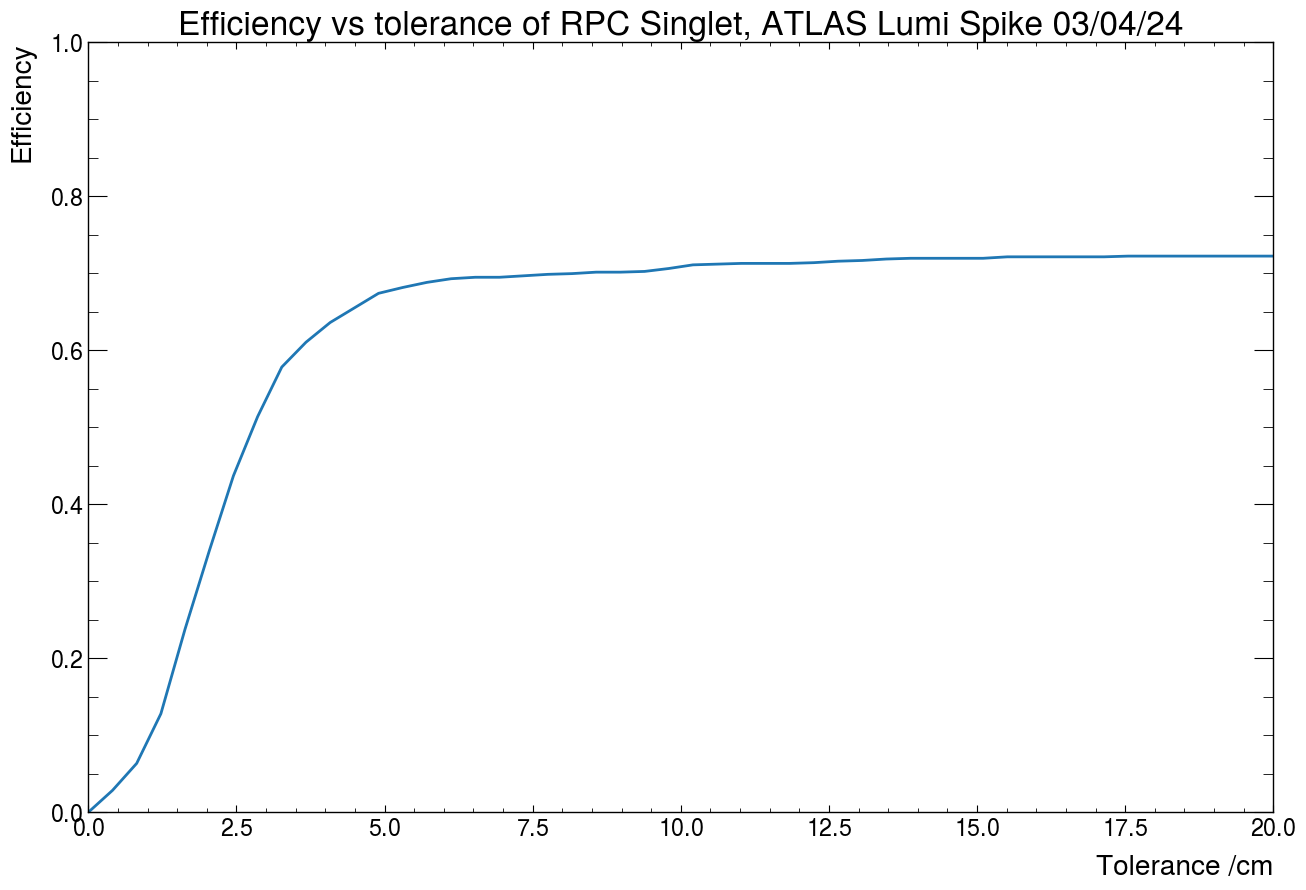

0.0
1638
0
0.40816326530612246
1638
77
0.8163265306122449
1638
192
1.2244897959183674
1638
257
1.6326530612244898
1638
374
2.0408163265306123
1638
473
2.4489795918367347
1638
549
2.857142857142857
1638
590
3.2653061224489797
1638
625
3.673469387755102
1638
652
4.081632653061225
1638
664
4.4897959183673475
1638
672
4.8979591836734695
1638
672
5.3061224489795915
1638
673
5.714285714285714
1638
673
6.122448979591837
1638
674
6.530612244897959
1638
678
6.938775510204081
1638
680
7.346938775510204
1638
681
7.755102040816327
1638
682
8.16326530612245
1638
682
8.571428571428571
1638
685
8.979591836734695
1638
686
9.387755102040817
1638
689
9.795918367346939
1638
690
10.204081632653061
1638
692
10.612244897959183
1638
692
11.020408163265307
1638
692
11.428571428571429
1638
692
11.83673469387755
1638
693
12.244897959183675
1638
693
12.653061224489797
1638
693
13.061224489795919
1638
693
13.46938775510204
1638
693
13.877551020408163
1638
693
14.285714285714286
1638
693
14.693877551020408
1638
69

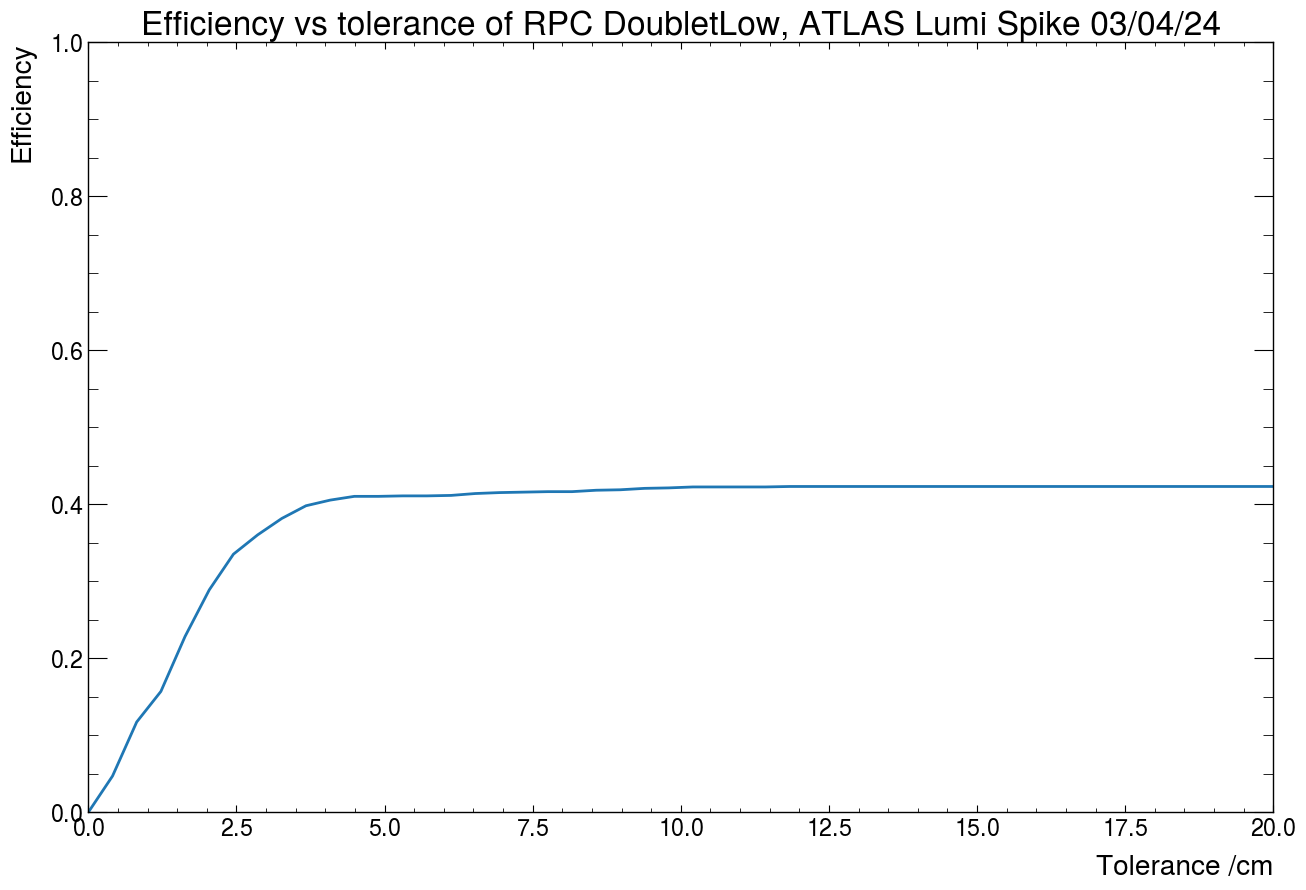

0.0
1717
0
0.40816326530612246
1717
45
0.8163265306122449
1717
175
1.2244897959183674
1717
356
1.6326530612244898
1717
472
2.0408163265306123
1717
555
2.4489795918367347
1717
624
2.857142857142857
1717
653
3.2653061224489797
1717
667
3.673469387755102
1717
670
4.081632653061225
1717
671
4.4897959183673475
1717
674
4.8979591836734695
1717
676
5.3061224489795915
1717
677
5.714285714285714
1717
677
6.122448979591837
1717
680
6.530612244897959
1717
680
6.938775510204081
1717
682
7.346938775510204
1717
682
7.755102040816327
1717
685
8.16326530612245
1717
685
8.571428571428571
1717
686
8.979591836734695
1717
688
9.387755102040817
1717
689
9.795918367346939
1717
690
10.204081632653061
1717
690
10.612244897959183
1717
692
11.020408163265307
1717
693
11.428571428571429
1717
693
11.83673469387755
1717
694
12.244897959183675
1717
694
12.653061224489797
1717
696
13.061224489795919
1717
697
13.46938775510204
1717
698
13.877551020408163
1717
699
14.285714285714286
1717
699
14.693877551020408
1717
69

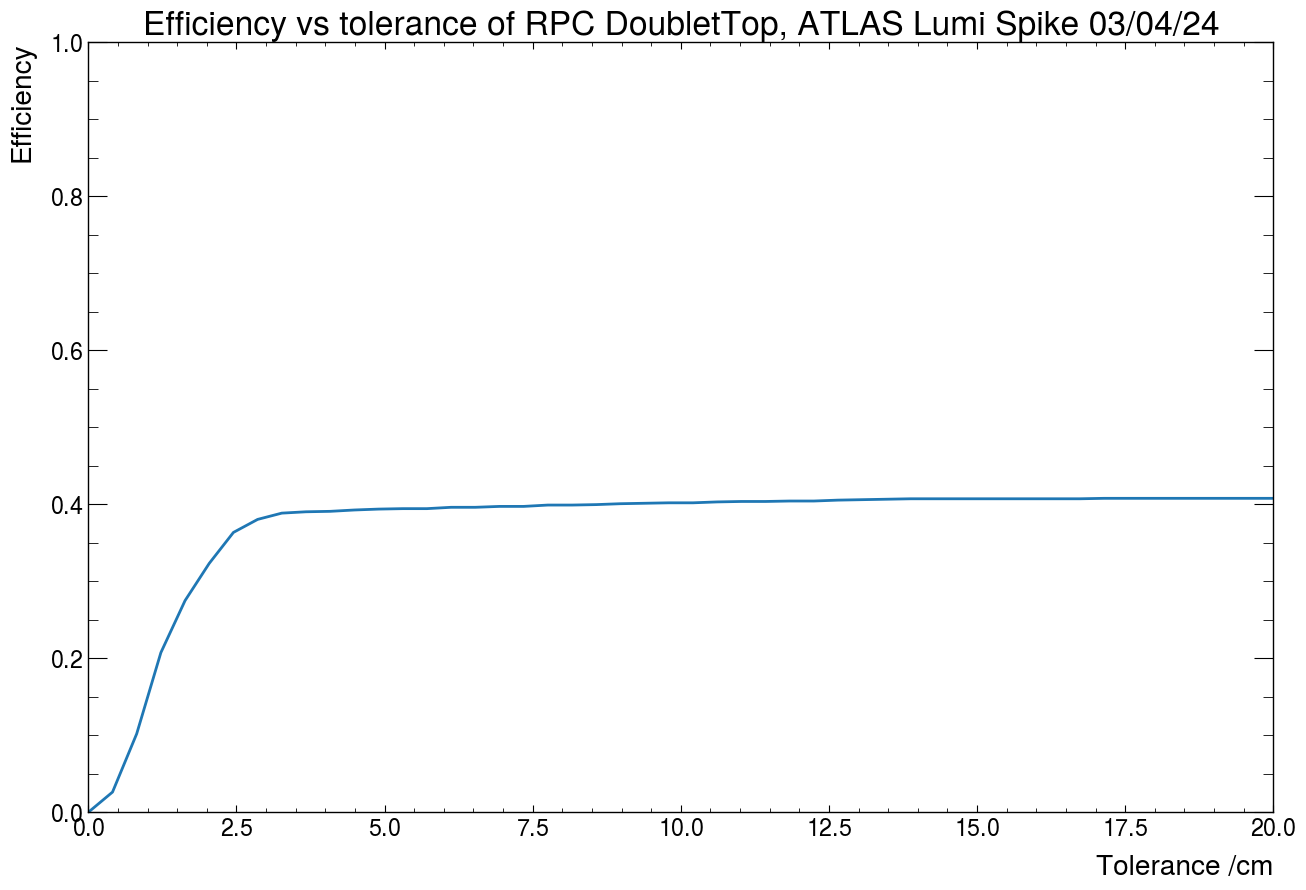

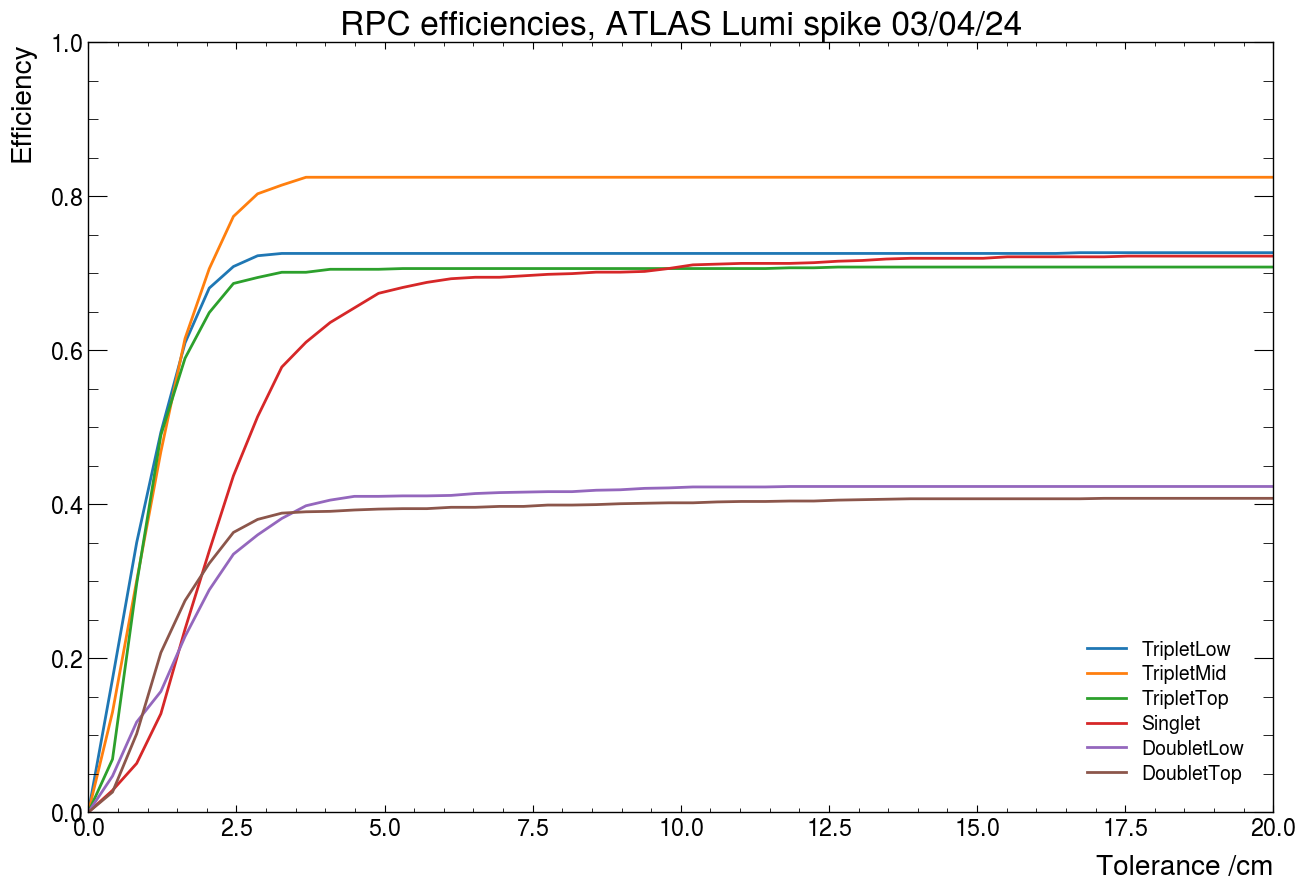

In [23]:
tolerances = np.linspace(0,20,50)

RPCS = ['TripletLow','TripletMid','TripletTop','Singlet','DoubletLow','DoubletTop']
efficiencies= []

for RPC in range(6):

    efficiencies_RPC = []

    for tol in tolerances:
        print(tol)
        efficiencies_RPC.append(calc_efficiency_RPC(coincident_hits_ATLAS_clustered,RPC,tol))

    efficiencies.append(efficiencies_RPC)

    # Zip the nested lists together
    toWrite = zip(efficiencies_RPC, tolerances)

    with open(f'{RPCS[RPC]}.csv', 'w', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerows(toWrite)

    plt.figure(figsize=(15,10))

    plt.plot(tolerances, efficiencies_RPC)
    plt.xlabel('Tolerance /cm')
    plt.ylabel('Efficiency')
    plt.ylim(0,1)

    plt.title(f'Efficiency vs tolerance of RPC {RPCS[RPC]}, ATLAS Lumi Spike 03/04/24')

    plt.show()

plt.figure(figsize=(15,10))

for ind,data in enumerate(efficiencies):
    plt.plot(tolerances,data,label=f'{RPCS[ind]}')

plt.title("RPC efficiencies, ATLAS Lumi spike 03/04/24")

plt.xlabel('Tolerance /cm')
plt.ylabel('Efficiency')

plt.ylim(0,1)

plt.legend()
plt.show()


In [24]:
Cosmics = ANT.importFromHDF5File(current_directory+"\\ProAnubisData\\ATLAS LUMINOSITY\\proAnubis_240403_1427_cosmics.h5")

data_cosmics = [sublist[:83169] for sublist in Cosmics]

c_etaHits, c_phiHits = ANT.divideHitCountsByRPC_Timed(data_cosmics)

#Time_window for coincidence set at 15 ns.
#Temporal Clustering
coincident_hits_cosmics = ANT.FindCoincidentHits(c_etaHits,c_phiHits,15)

#Spatial Clustering
coincident_hits_cosmics_clustered = ANT.cluster(coincident_hits_cosmics)

print(len(coincident_hits_cosmics_clustered))

0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0%
0

0.0
404
0
0.40816326530612246
404
46
0.8163265306122449
404
114
1.2244897959183674
404
178
1.6326530612244898
404
221
2.0408163265306123
404
257
2.4489795918367347
404
275
2.857142857142857
404
277
3.2653061224489797
404
279
3.673469387755102
404
279
4.081632653061225
404
279
4.4897959183673475
404
280
4.8979591836734695
404
280
5.3061224489795915
404
280
5.714285714285714
404
280
6.122448979591837
404
280
6.530612244897959
404
280
6.938775510204081
404
280
7.346938775510204
404
280
7.755102040816327
404
280
8.16326530612245
404
280
8.571428571428571
404
280
8.979591836734695
404
280
9.387755102040817
404
280
9.795918367346939
404
280
10.204081632653061
404
280
10.612244897959183
404
280
11.020408163265307
404
280
11.428571428571429
404
280
11.83673469387755
404
280
12.244897959183675
404
280
12.653061224489797
404
280
13.061224489795919
404
280
13.46938775510204
404
280
13.877551020408163
404
280
14.285714285714286
404
280
14.693877551020408
404
280
15.10204081632653
404
280
15.510204

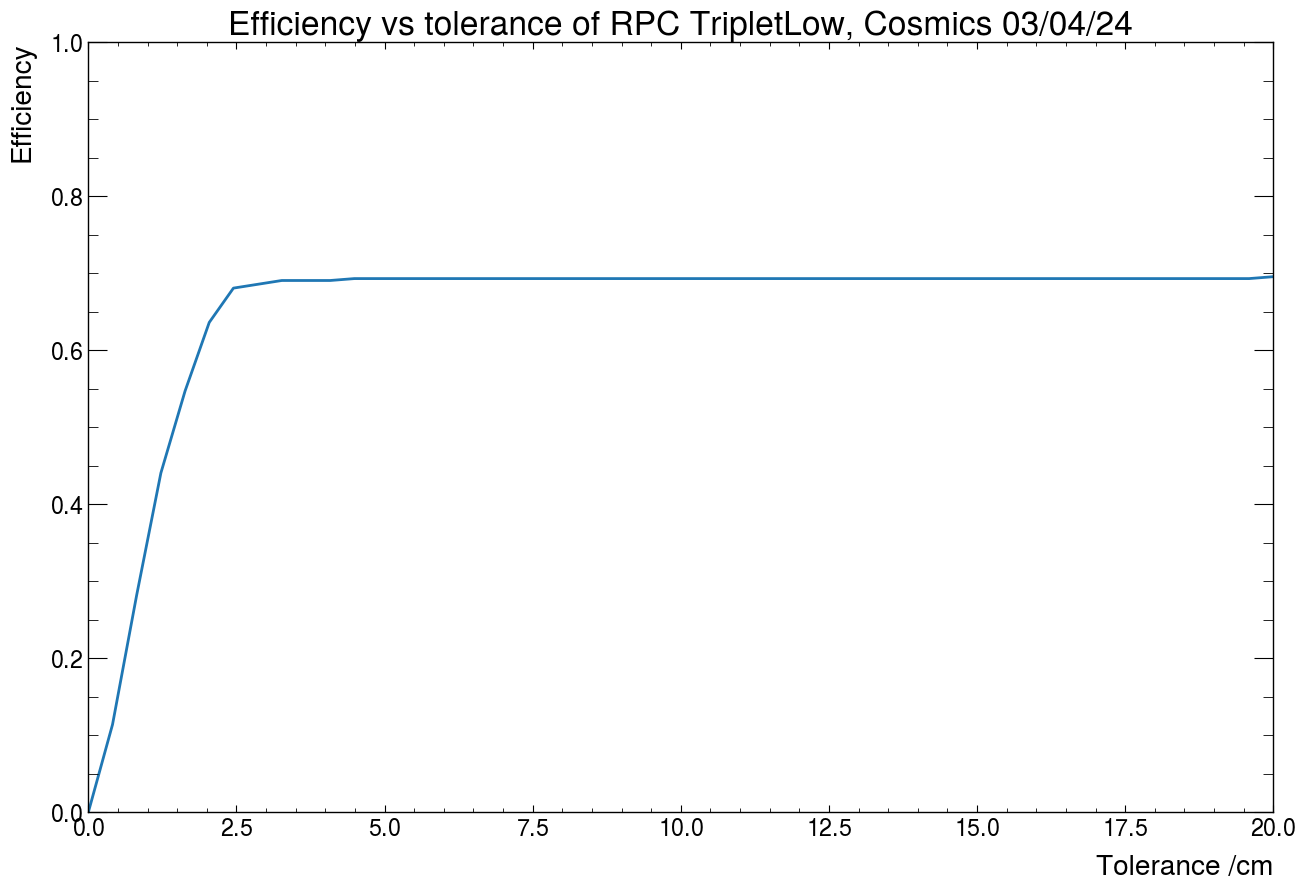

0.0
340
0
0.40816326530612246
340
43
0.8163265306122449
340
102
1.2244897959183674
340
160
1.6326530612244898
340
209
2.0408163265306123
340
249
2.4489795918367347
340
272
2.857142857142857
340
278
3.2653061224489797
340
279
3.673469387755102
340
281
4.081632653061225
340
281
4.4897959183673475
340
282
4.8979591836734695
340
282
5.3061224489795915
340
282
5.714285714285714
340
282
6.122448979591837
340
282
6.530612244897959
340
282
6.938775510204081
340
282
7.346938775510204
340
282
7.755102040816327
340
282
8.16326530612245
340
282
8.571428571428571
340
282
8.979591836734695
340
282
9.387755102040817
340
282
9.795918367346939
340
282
10.204081632653061
340
282
10.612244897959183
340
282
11.020408163265307
340
282
11.428571428571429
340
282
11.83673469387755
340
282
12.244897959183675
340
282
12.653061224489797
340
282
13.061224489795919
340
282
13.46938775510204
340
283
13.877551020408163
340
283
14.285714285714286
340
283
14.693877551020408
340
283
15.10204081632653
340
283
15.510204

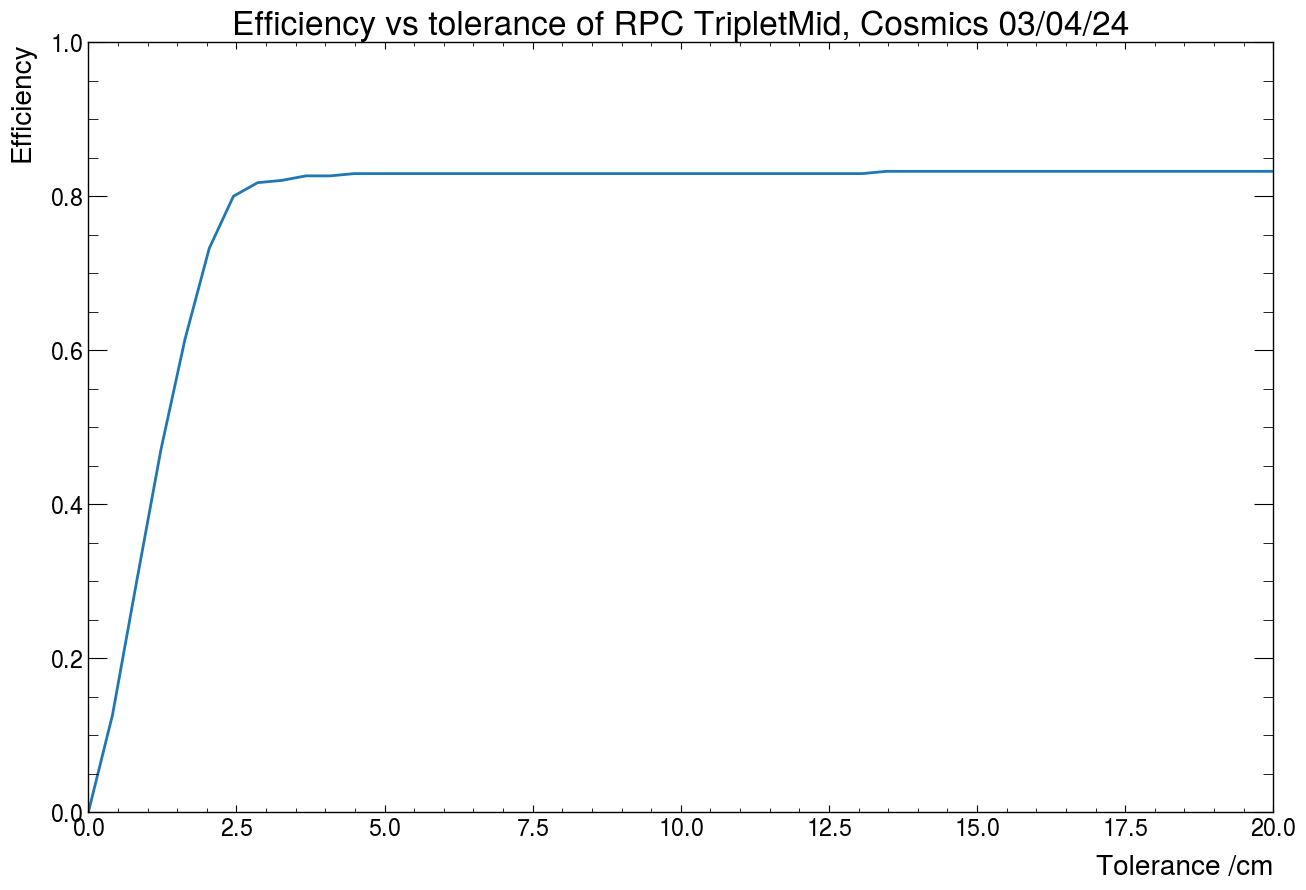

0.0
386
0
0.40816326530612246
386
26
0.8163265306122449
386
95
1.2244897959183674
386
171
1.6326530612244898
386
214
2.0408163265306123
386
249
2.4489795918367347
386
268
2.857142857142857
386
277
3.2653061224489797
386
279
3.673469387755102
386
279
4.081632653061225
386
279
4.4897959183673475
386
280
4.8979591836734695
386
280
5.3061224489795915
386
281
5.714285714285714
386
281
6.122448979591837
386
281
6.530612244897959
386
281
6.938775510204081
386
281
7.346938775510204
386
281
7.755102040816327
386
281
8.16326530612245
386
281
8.571428571428571
386
281
8.979591836734695
386
281
9.387755102040817
386
281
9.795918367346939
386
281
10.204081632653061
386
281
10.612244897959183
386
281
11.020408163265307
386
281
11.428571428571429
386
281
11.83673469387755
386
281
12.244897959183675
386
281
12.653061224489797
386
281
13.061224489795919
386
281
13.46938775510204
386
281
13.877551020408163
386
281
14.285714285714286
386
281
14.693877551020408
386
281
15.10204081632653
386
281
15.5102040

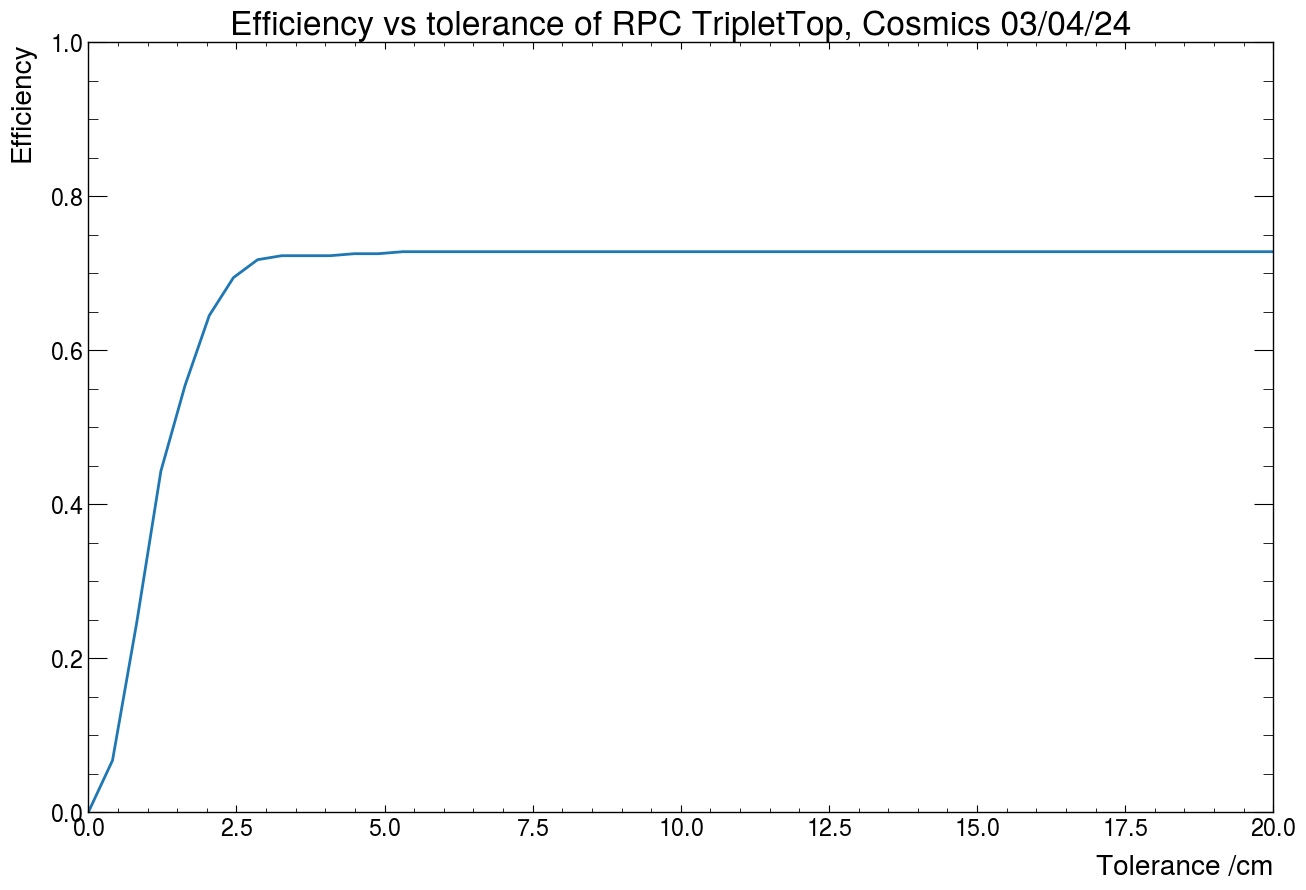

0.0
440
0
0.40816326530612246
440
10
0.8163265306122449
440
22
1.2244897959183674
440
39
1.6326530612244898
440
81
2.0408163265306123
440
118
2.4489795918367347
440
150
2.857142857142857
440
175
3.2653061224489797
440
205
3.673469387755102
440
222
4.081632653061225
440
238
4.4897959183673475
440
253
4.8979591836734695
440
263
5.3061224489795915
440
269
5.714285714285714
440
275
6.122448979591837
440
275
6.530612244897959
440
278
6.938775510204081
440
278
7.346938775510204
440
279
7.755102040816327
440
279
8.16326530612245
440
280
8.571428571428571
440
280
8.979591836734695
440
280
9.387755102040817
440
280
9.795918367346939
440
280
10.204081632653061
440
280
10.612244897959183
440
282
11.020408163265307
440
284
11.428571428571429
440
286
11.83673469387755
440
290
12.244897959183675
440
292
12.653061224489797
440
292
13.061224489795919
440
292
13.46938775510204
440
292
13.877551020408163
440
293
14.285714285714286
440
293
14.693877551020408
440
293
15.10204081632653
440
293
15.510204081

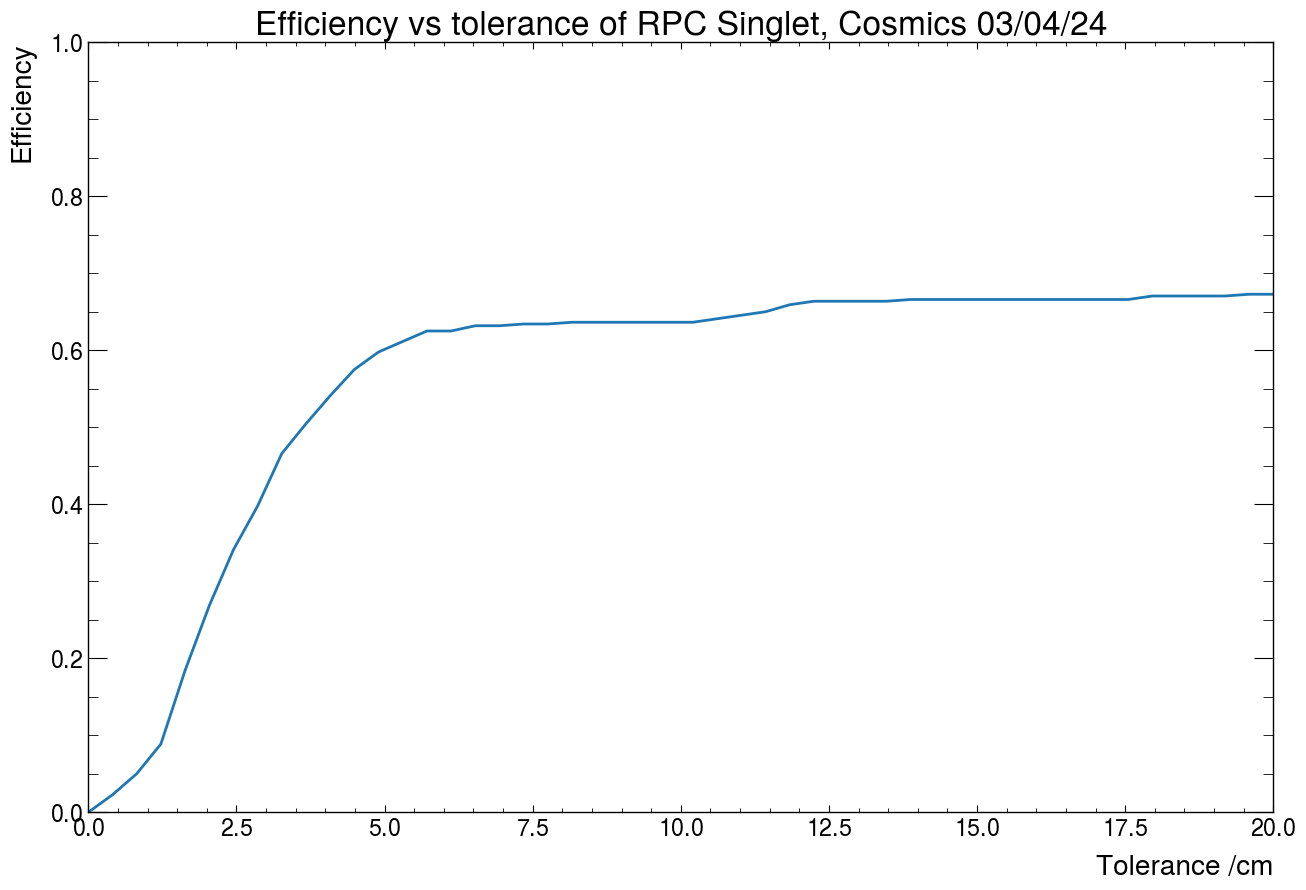

0.0
605
0
0.40816326530612246
605
25
0.8163265306122449
605
66
1.2244897959183674
605
88
1.6326530612244898
605
137
2.0408163265306123
605
184
2.4489795918367347
605
211
2.857142857142857
605
229
3.2653061224489797
605
238
3.673469387755102
605
252
4.081632653061225
605
255
4.4897959183673475
605
255
4.8979591836734695
605
258
5.3061224489795915
605
259
5.714285714285714
605
259
6.122448979591837
605
262
6.530612244897959
605
263
6.938775510204081
605
263
7.346938775510204
605
265
7.755102040816327
605
267
8.16326530612245
605
267
8.571428571428571
605
267
8.979591836734695
605
267
9.387755102040817
605
268
9.795918367346939
605
268
10.204081632653061
605
268
10.612244897959183
605
268
11.020408163265307
605
268
11.428571428571429
605
269
11.83673469387755
605
269
12.244897959183675
605
270
12.653061224489797
605
270
13.061224489795919
605
270
13.46938775510204
605
270
13.877551020408163
605
270
14.285714285714286
605
271
14.693877551020408
605
271
15.10204081632653
605
271
15.51020408

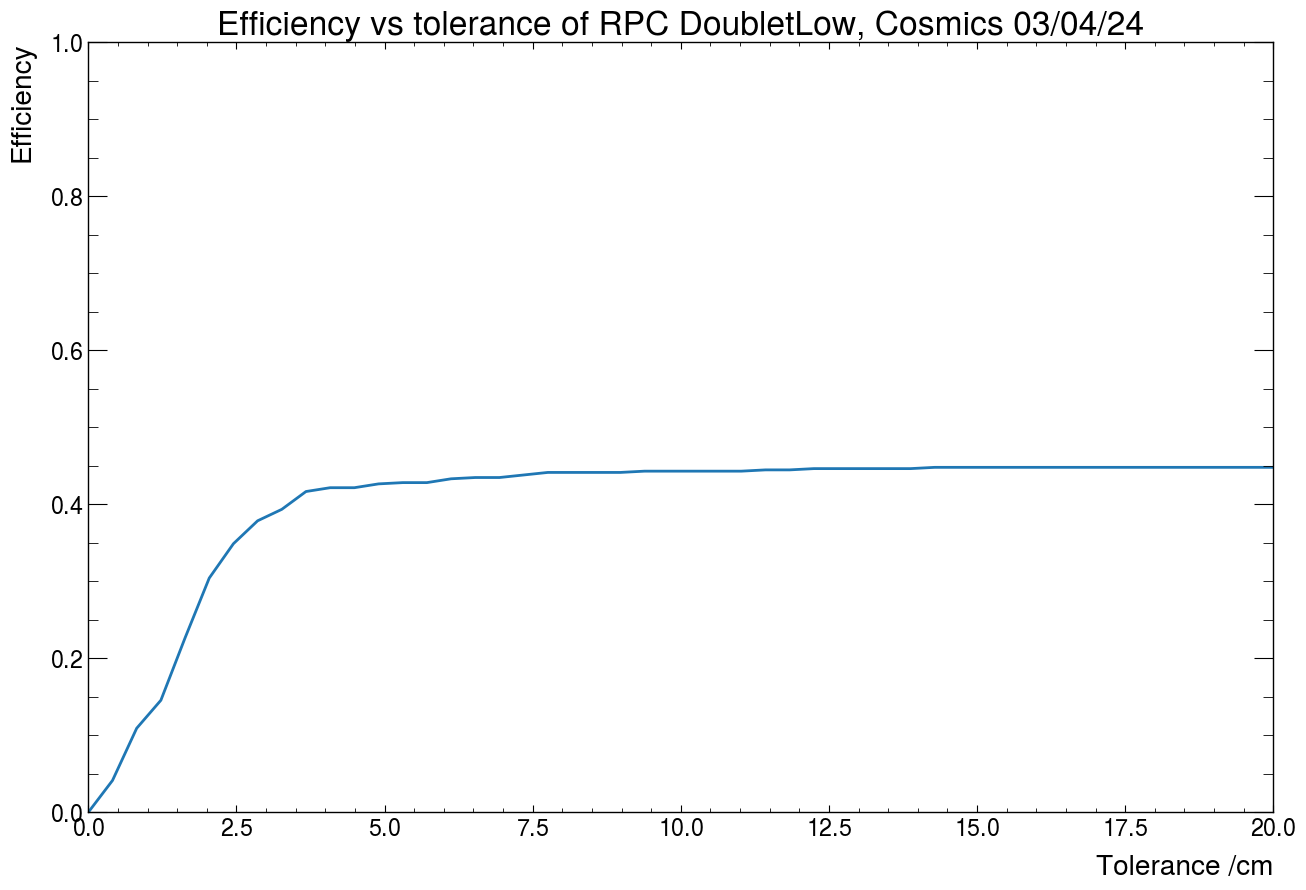

0.0
703
0
0.40816326530612246
703
19
0.8163265306122449
703
61
1.2244897959183674
703
122
1.6326530612244898
703
179
2.0408163265306123
703
213
2.4489795918367347
703
248
2.857142857142857
703
252
3.2653061224489797
703
257
3.673469387755102
703
260
4.081632653061225
703
262
4.4897959183673475
703
265
4.8979591836734695
703
266
5.3061224489795915
703
267
5.714285714285714
703
268
6.122448979591837
703
268
6.530612244897959
703
268
6.938775510204081
703
268
7.346938775510204
703
268
7.755102040816327
703
270
8.16326530612245
703
270
8.571428571428571
703
270
8.979591836734695
703
271
9.387755102040817
703
271
9.795918367346939
703
271
10.204081632653061
703
271
10.612244897959183
703
271
11.020408163265307
703
272
11.428571428571429
703
272
11.83673469387755
703
272
12.244897959183675
703
272
12.653061224489797
703
274
13.061224489795919
703
274
13.46938775510204
703
274
13.877551020408163
703
274
14.285714285714286
703
274
14.693877551020408
703
274
15.10204081632653
703
274
15.5102040

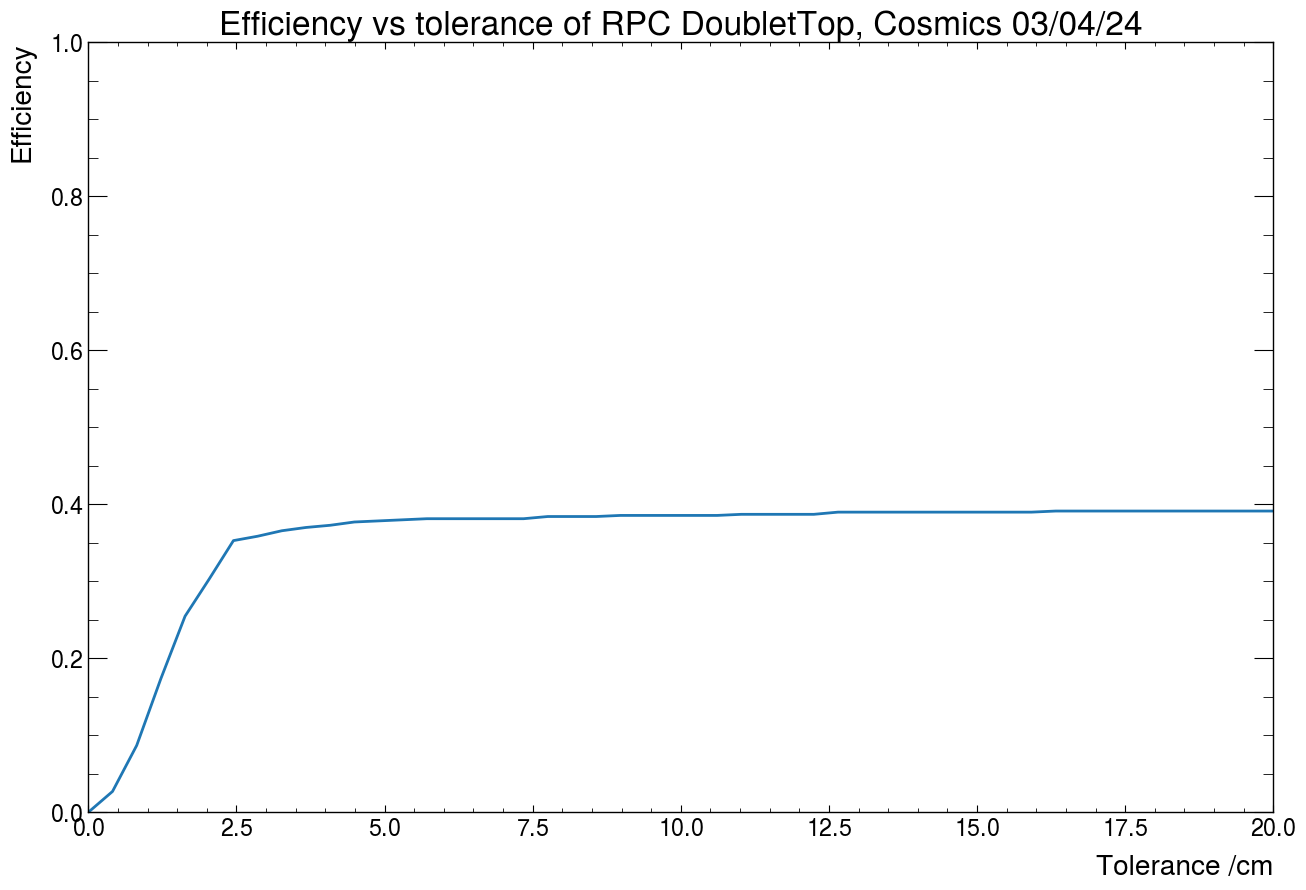

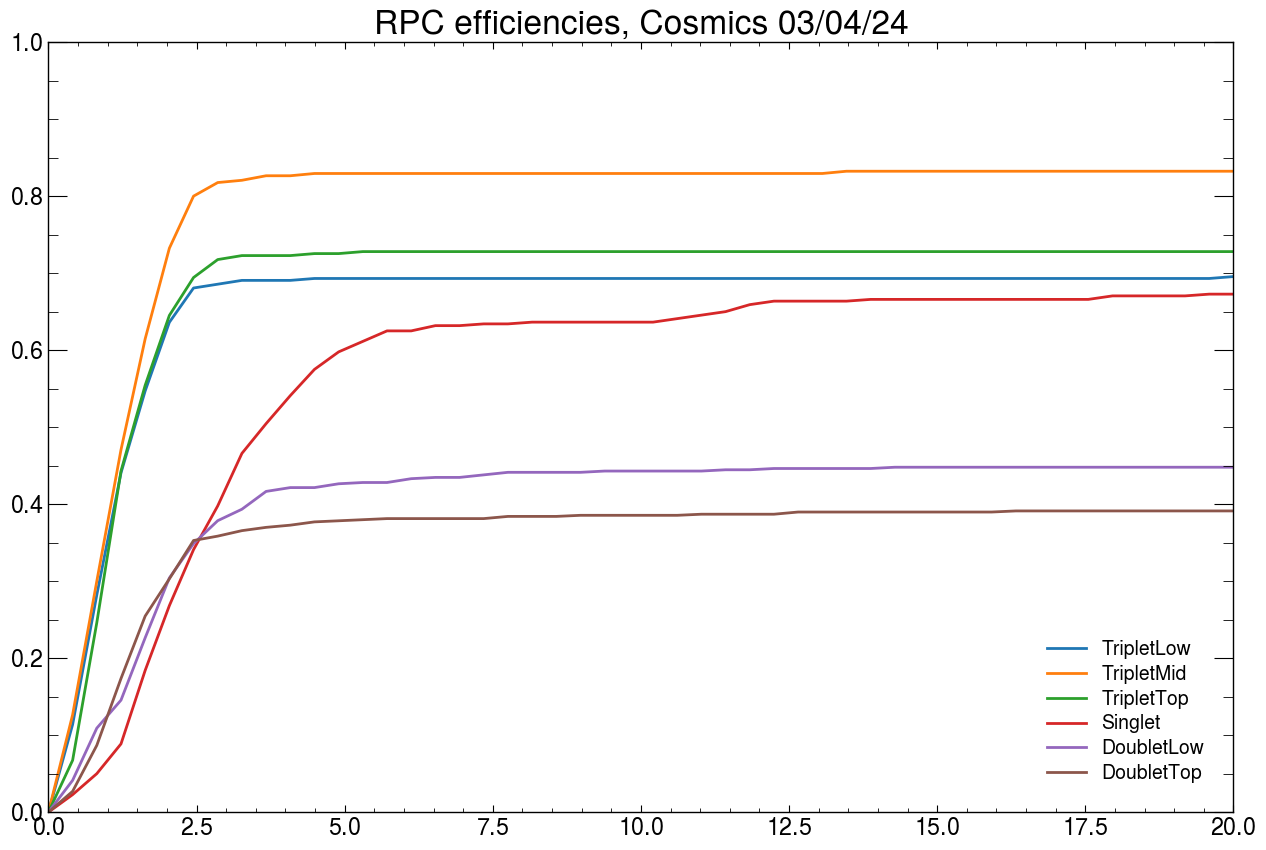

In [25]:
tolerances = np.linspace(0,20,50)

RPCS = ['TripletLow','TripletMid','TripletTop','Singlet','DoubletLow','DoubletTop']
efficiencies= []

for RPC in range(6):

    efficiencies_RPC = []

    for tol in tolerances:
        print(tol)
        efficiencies_RPC.append(calc_efficiency_RPC(coincident_hits_cosmics_clustered,RPC,tol))

    efficiencies.append(efficiencies_RPC)

    # Zip the nested lists together
    toWrite = zip(efficiencies_RPC, tolerances)

    with open(f'{RPCS[RPC]}.csv', 'w', newline='') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerows(toWrite)

    plt.figure(figsize=(15,10))

    plt.plot(tolerances, efficiencies_RPC)
    plt.xlabel('Tolerance /cm')
    plt.ylabel('Efficiency')
    plt.ylim(0,1)

    plt.title(f'Efficiency vs tolerance of RPC {RPCS[RPC]}, Cosmics 03/04/24')

    plt.show()

plt.figure(figsize=(15,10))

for ind,data in enumerate(efficiencies):
    plt.plot(tolerances,data,label=f'{RPCS[ind]}')

plt.title("RPC efficiencies, Cosmics 03/04/24")

plt.ylim(0,1)

plt.legend()
plt.show()


Now doing the same but with minimal constraints on the RPC under test

In [68]:
import re

def reconstruct_timed_Chi2_ByRPC(event,max_cluster_size, RPC_excluded):

    #timed tag indicates that timing information from RPC is used to determine direction of vertical transversal of "particle" in the event.

    max_Chi2 = 10

    # event = ['Event x',TIMEBIN, [[[RPC1_PHI_CLUSTERS],[RPC1_ETA_CLUSTERS]],[[...],[...]],...]
    RPC_heights = [0.6,1.8,3.0,61.8,121.8,123] #Heights of middle point of each RPC, measured from the bottom of the Triplet Low RPC. Units are cm.

    event_id_string = event[0]
    event_id = int(re.search(r'\d+$', event_id_string).group())

    #Extract x and y coords of cluster in event
    coords = ANT.extract_coords_timed_Chi2(event,max_cluster_size)

     # Filter out coords of RPC under test 

    test_coords = coords[RPC_excluded]

    coords[RPC_excluded] = [[],[],"N"] 

    # Count the number of empty RPCs
    empty_RPC_count = sum(1 for item in coords if item == [[], [],'N'])

    # If less than 3 elements of coords are occupied, exit the function
    if empty_RPC_count > 3:
        #print("Failed to reconstruct, not enough coords")
        return None  # Exit the function
    
    cross_chamberness = 0

    if coords[0] != [[], [], 'N'] or coords[1] != [[], [], 'N'] or coords[2] != [[], [], 'N']:
        cross_chamberness += 1

    if coords[3] != [[], [], 'N']:
        cross_chamberness += 1

    if coords[4] != [[], [], 'N'] or coords[5] != [[], [], 'N']:
        cross_chamberness += 1

    if cross_chamberness < 2:
        #print("Failed to reconstruct, too few chambers")
        return None

    #ITERATING OVER EVERY POSSIBLE COMBINATION OF x,y,z over all 3 RPCs (limited to one x,y per RPC).
    #Doesn't look particularly nice, but there are not many coordinates to loop over usually....

    combinations = ANT.generate_hit_coords_combo_Chi2(coords,RPC_heights)

    #Now for each combo in combinations, attempt to reconstruct a path. See which one gives the best trajectory.

    #If success, print parameters of fitting function.
    #If fail, print reconstruction failed.

    Chi2_current = np.inf
    optimised_coords = None
    optimised_d= None
    optimised_centroid= None
    dT = [np.inf,np.inf]

    for ind,combo in enumerate(combinations):

        centroid, d, Chi2, coordinates, delta_T, delta_Z= ANT.fit_event_chi2(combo)
        if Chi2 < Chi2_current:

            # If new fit is better than old then replace old fit properties.
            dZ = delta_Z 
            dT = delta_T
            Chi2_current = Chi2
            optimised_centroid = centroid
            optimised_d = d
            optimised_coords = coordinates

    #if dT>0 this implies the particles hit the higher RPC after the lower one, so the particle is travelling upwards here.
    #Vice-versa for dT < 0.

    event

    #dT = 0 case?

    if dT[0] != np.inf:

        if dT[0] > 0:
            if optimised_d[2] < 0:
                optimised_d = np.multiply(optimised_d,-1)
        else:
            if optimised_d[2] > 0:
                optimised_d = np.multiply(optimised_d,-1)

        if Chi2_current<max_Chi2:
            return optimised_centroid, optimised_d, optimised_coords, combinations, Chi2_current, dT, dZ, test_coords, event_id, event[1]

    else:
        #print("Failed to reconstruct, Chi2 too large")
        #return optimised_centroid, optimised_d, optimised_coords, combinations, residuals_current
        return None

def does_RPC_detect_muon_relaxed(initial_time, time_tol,event_id,etaHits,phiHits,RPC):
    #This is a more relaxed probe of the test RPC. We have no restrictions on cluster size or spatial tolerance of hit 
    #-> geometrical effects completely ignored

    #print(initial_time)

    #Instead, I am probing the test RPC temporally

    #Can do this separately for eta and phi!
    #Initial_time is the time of the first strip being hit in an event. 
    # Check if hit produced in: initial_time-time_tol < T <initial_time+time_tol

    #Still including corrupted timestamps here, indeed a really rather RELAXED probe!

    event_index = event_id - 1

    eta_hits = etaHits[RPC][event_index]
    phi_hits = phiHits[RPC][event_index]

    phi_counter = 0
    eta_counter = 0

    for channel in eta_hits:
        #print(f"eta channel:{channel}")
        if channel != []:
            for hit in channel:
                if initial_time-time_tol <= hit <= initial_time + time_tol:
                    eta_counter+=1

    for channel in phi_hits:
        #print(f"phi Channel: {channel}")
        if channel != []:
            for hit in channel:
                if initial_time-time_tol <= hit <= initial_time + time_tol:
                    phi_counter+=1

    # hit_query = [phiHit,etaHit,andHit]

    hit_query = [False,False,False]

    if phi_counter > 0:
        hit_query[0]= True

    if eta_counter > 0:
        hit_query[1]= True
    
    if phi_counter>0 and eta_counter >0 :
        hit_query[2]= True
    

    return hit_query

In [69]:
def calc_efficiency_RPC_relaxed(dataset,RPC,phiHits,etaHits,time_tol):
    # RPC input is number 0 to 5.
    # dataset is output of ANT.cluser()
    # time_tol here is in ns, t-dT < t < t+dT
    
    events = ANT.filter_events_by_RPC(dataset,2,5,RPC)

    possible_reconstructions = 0
    successful_reconstructions_eta = 0
    successful_reconstructions_phi = 0
    successful_reconstructions_combined = 0

    for i,event in enumerate(events):

        #print(f"Event index {i}")

        E_recon = reconstruct_timed_Chi2_ByRPC(event,3,RPC)

        if E_recon:

            if len(E_recon[2])>=5:
                #Adding this check to see if other 5 RPCs are in reconstructed event.
                #This is necessary to ensure the reconstructed path is accurate.

                muon_coords = ANT.does_muon_hit_RPC(E_recon[0],E_recon[1],RPC)

                if muon_coords:
                    #Only continue if muon actually passes through the RPC. 

                    possible_reconstructions+=1 

                    hit_query = does_RPC_detect_muon_relaxed(E_recon[9],time_tol,E_recon[8],etaHits,phiHits,RPC)

                    if hit_query[0]:
                        successful_reconstructions_phi+=1
                    if hit_query[1]:
                        successful_reconstructions_eta+=1
                    if hit_query[2]:
                        successful_reconstructions_combined+=1


    print(possible_reconstructions)
    print(successful_reconstructions_eta)
    print(successful_reconstructions_phi)
    print(successful_reconstructions_combined)

    efficiences = [successful_reconstructions_phi/possible_reconstructions,successful_reconstructions_eta/possible_reconstructions,successful_reconstructions_combined/possible_reconstructions]

    return efficiences

In [70]:
test = calc_efficiency_RPC_relaxed(coincident_hits_ATLAS_clustered,5,phiHits,etaHits,25)

1717
1294
918
797


0
999
0
29
0
4
999
0
521
0
8
999
25
750
24
12
999
213
860
205
16
999
524
879
498
20
999
686
880
653
24
999
760
880
725
28
999
783
880
747
32
999
786
880
750
36
999
786
880
750
40
999
786
880
750
44
999
786
880
750
48
999
786
880
750
52
999
786
880
750
56
999
786
880
750
60
999
786
880
750
64
999
786
880
750
68
999
786
880
750
72
999
786
880
750
76
999
786
880
750
80
999
786
880
750
84
999
786
880
750
88
999
786
880
750
92
999
786
880
750
96
999
786
880
750
100
999
786
880
750
150
999
786
880
750
200
999
786
880
750
250
999
786
880
750
300
999
786
880
750
350
999
786
880
750
400
999
786
880
750
450
999
786
880
750
500
999
786
880
750
550
999
786
880
750
600
999
786
880
750
650
999
786
880
750
700
999
786
880
750
750
999
786
880
750
800
999
786
881
750
850
999
787
881
751
900
999
787
881
751
950
999
787
881
751
1000
999
787
881
751
1050
999
787
881
751
1100
999
787
881
751
1150
999
787
881
751
1200
999
787
881
751
1250
999
787
881
751


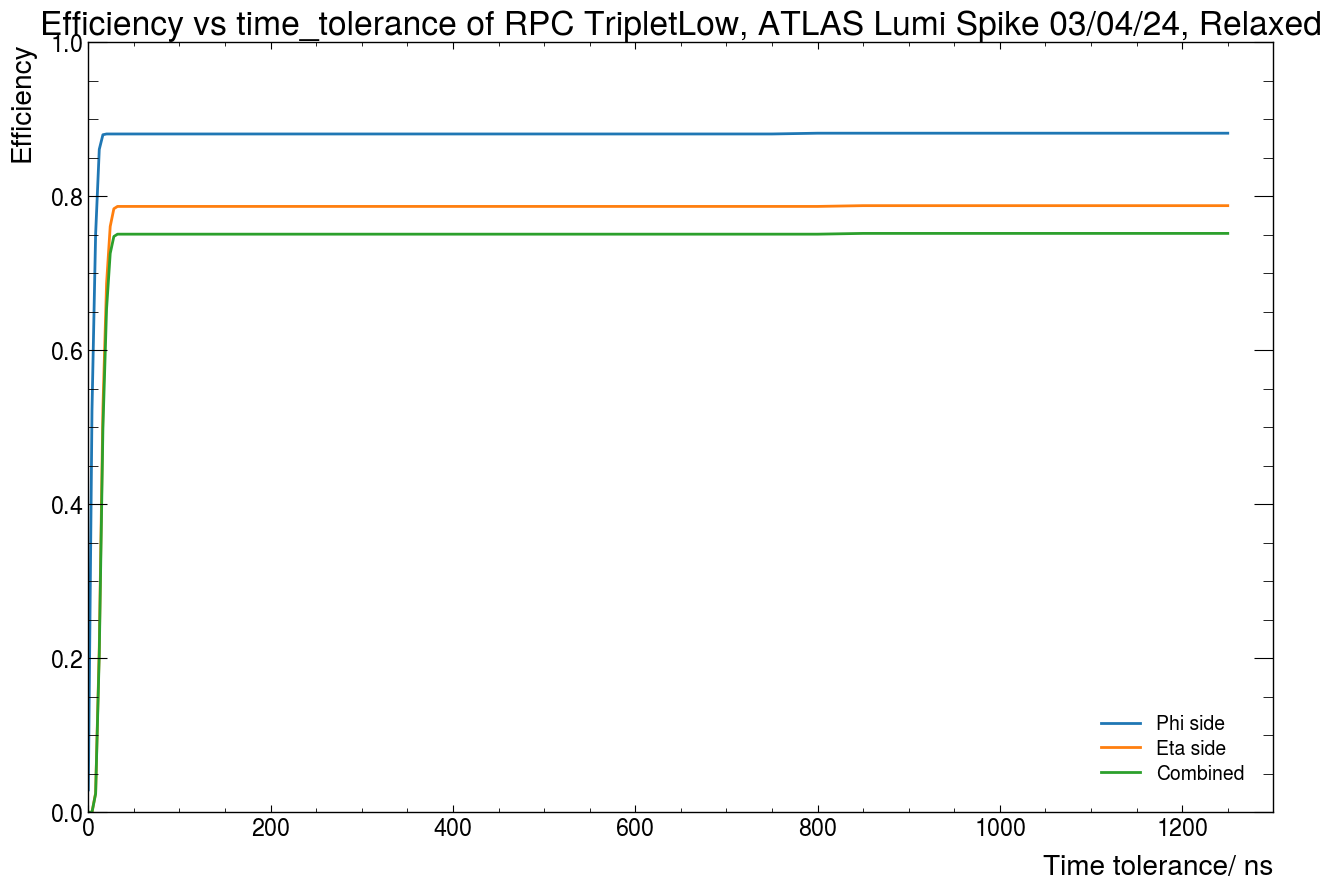

0
884
0
97
0
4
884
0
587
0
8
884
11
723
11
12
884
125
793
122
16
884
418
803
406
20
884
645
803
628
24
884
730
803
706
28
884
761
803
736
32
884
768
805
745
36
884
769
805
746
40
884
769
807
747
44
884
769
809
749
48
884
769
809
749
52
884
769
809
749
56
884
769
809
749
60
884
769
809
749
64
884
769
809
749
68
884
769
809
749
72
884
769
809
749
76
884
769
809
749
80
884
769
809
749
84
884
769
809
749
88
884
769
809
749
92
884
769
809
749
96
884
769
809
749
100
884
769
809
749
150
884
770
810
750
200
884
770
810
750
250
884
770
810
750
300
884
770
810
750
350
884
770
810
750
400
884
770
810
750
450
884
770
810
750
500
884
770
810
750
550
884
770
810
750
600
884
770
810
750
650
884
770
810
750
700
884
770
810
750
750
884
770
810
750
800
884
770
810
750
850
884
770
810
750
900
884
770
810
750
950
884
770
810
750
1000
884
770
810
750
1050
884
770
810
750
1100
884
770
810
750
1150
884
770
810
750
1200
884
770
810
750
1250
884
770
810
750


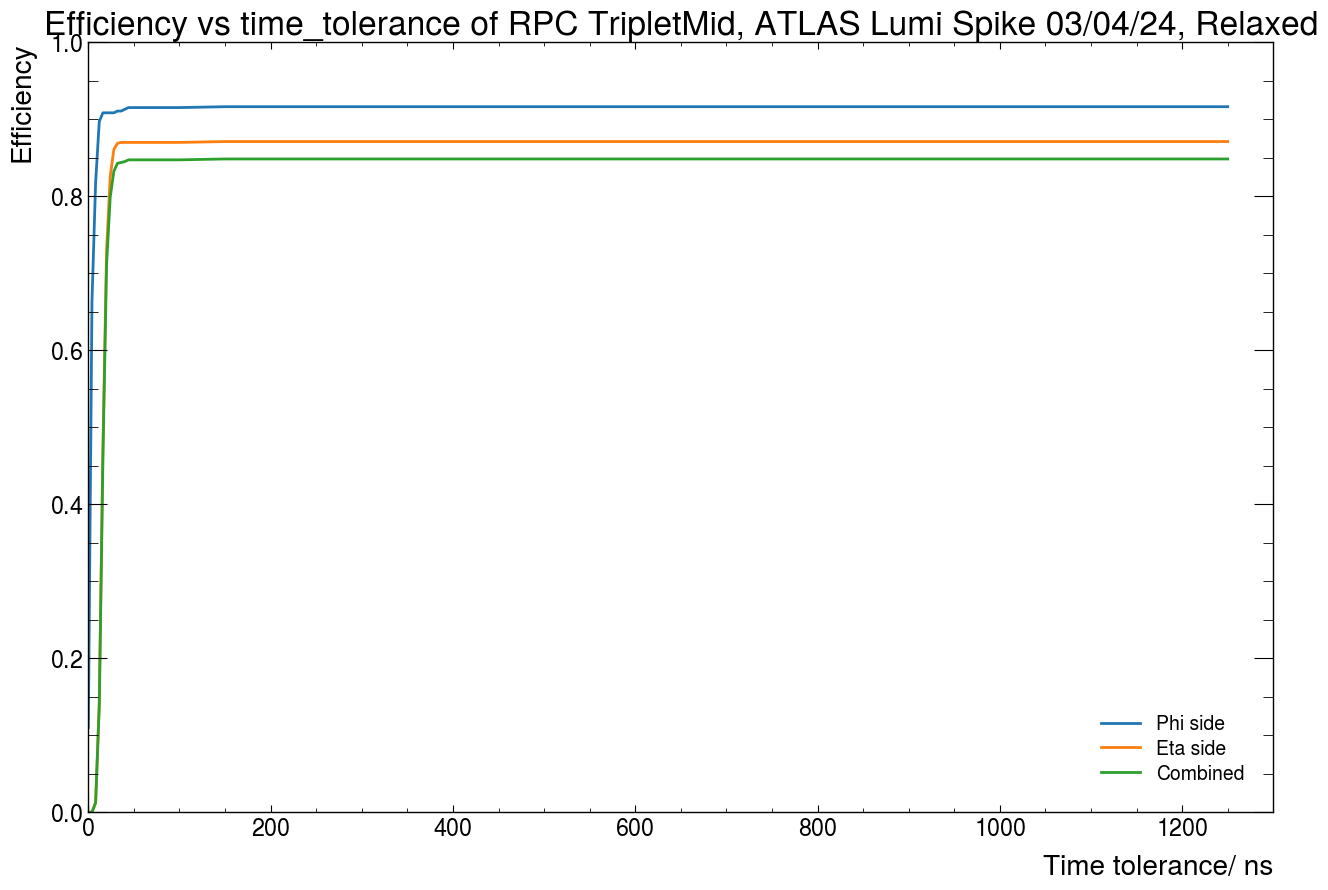

0
1031
1
622
0
4
1031
1
721
0
8
1031
19
830
16
12
1031
192
884
170
16
1031
502
889
457
20
1031
708
889
654
24
1031
791
889
733
28
1031
815
891
754
32
1031
822
892
757
36
1031
822
892
757
40
1031
822
895
757
44
1031
824
895
759
48
1031
824
895
759
52
1031
824
895
759
56
1031
827
895
762
60
1031
827
895
762
64
1031
827
895
762
68
1031
827
895
762
72
1031
827
895
762
76
1031
827
895
762
80
1031
827
895
762
84
1031
827
895
762
88
1031
827
895
762
92
1031
827
895
762
96
1031
827
895
762
100
1031
827
895
762
150
1031
827
895
762
200
1031
827
895
762
250
1031
827
895
762
300
1031
827
895
762
350
1031
827
895
762
400
1031
827
895
762
450
1031
827
895
762
500
1031
827
895
762
550
1031
827
895
762
600
1031
827
896
763
650
1031
827
896
763
700
1031
827
896
763
750
1031
827
896
763
800
1031
827
896
763
850
1031
827
896
763
900
1031
827
896
763
950
1031
827
896
763
1000
1031
827
896
763
1050
1031
827
896
763
1100
1031
827
896
763
1150
1031
827
896
763
1200
1031
827
897
764
1250
1031
827
897
764


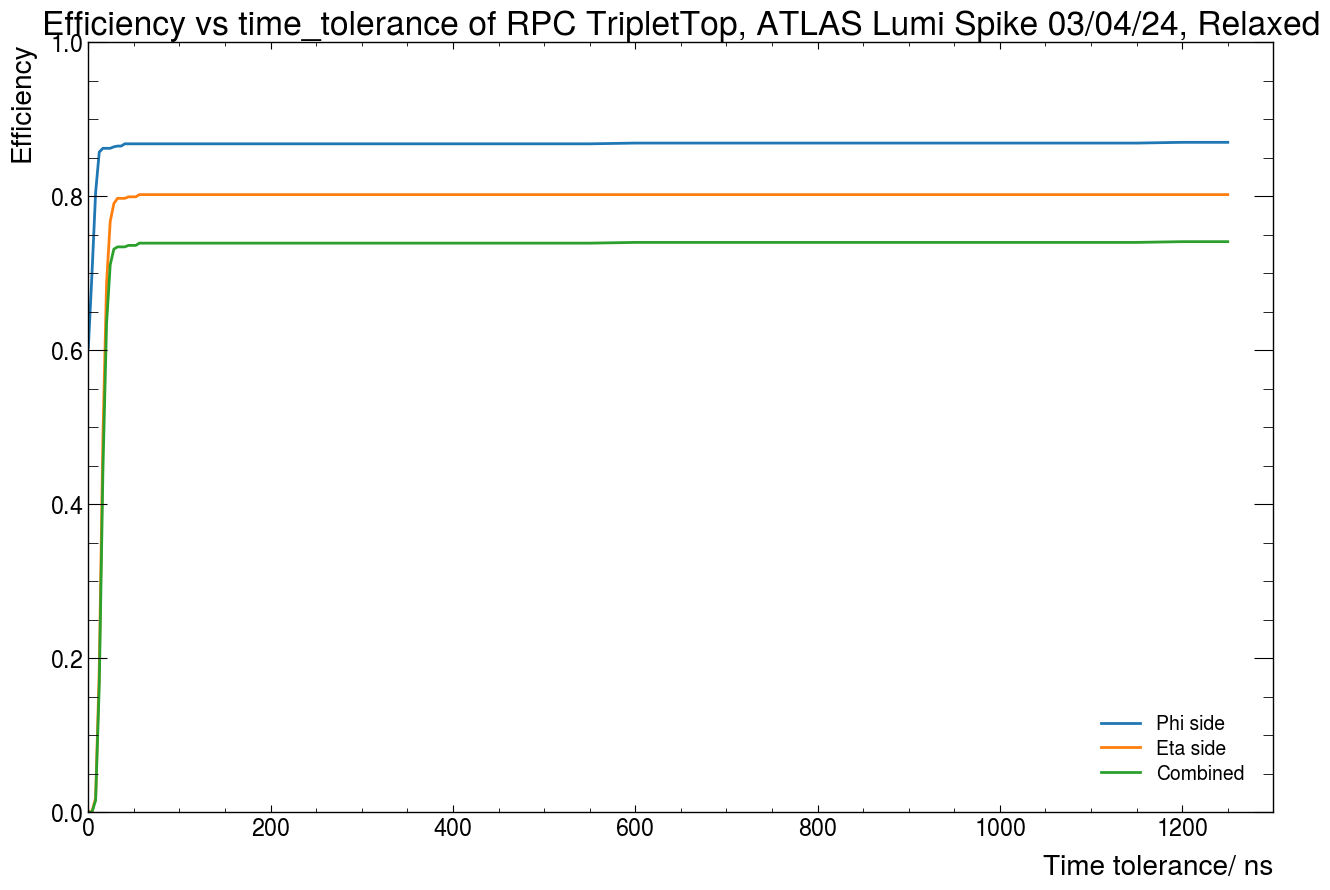

0
1055
0
23
0
4
1055
0
577
0
8
1055
11
933
10
12
1055
203
946
199
16
1055
590
948
575
20
1055
810
948
784
24
1055
869
948
841
28
1055
882
949
854
32
1055
883
950
855
36
1055
883
955
855
40
1055
883
956
855
44
1055
885
956
857
48
1055
888
956
860
52
1055
891
956
863
56
1055
891
957
863
60
1055
891
957
863
64
1055
891
957
863
68
1055
891
957
863
72
1055
891
958
863
76
1055
891
959
863
80
1055
891
959
863
84
1055
891
959
863
88
1055
891
959
863
92
1055
891
959
863
96
1055
891
959
863
100
1055
891
959
863
150
1055
891
962
864
200
1055
891
962
864
250
1055
891
962
864
300
1055
891
963
864
350
1055
892
964
865
400
1055
892
964
865
450
1055
892
964
865
500
1055
892
966
865
550
1055
892
966
865
600
1055
892
967
865
650
1055
893
969
868
700
1055
893
970
868
750
1055
893
970
868
800
1055
893
970
868
850
1055
893
971
868
900
1055
893
971
868
950
1055
893
971
868
1000
1055
893
971
868
1050
1055
893
971
868
1100
1055
893
972
868
1150
1055
893
973
868
1200
1055
893
973
868
1250
1055
893
973
868


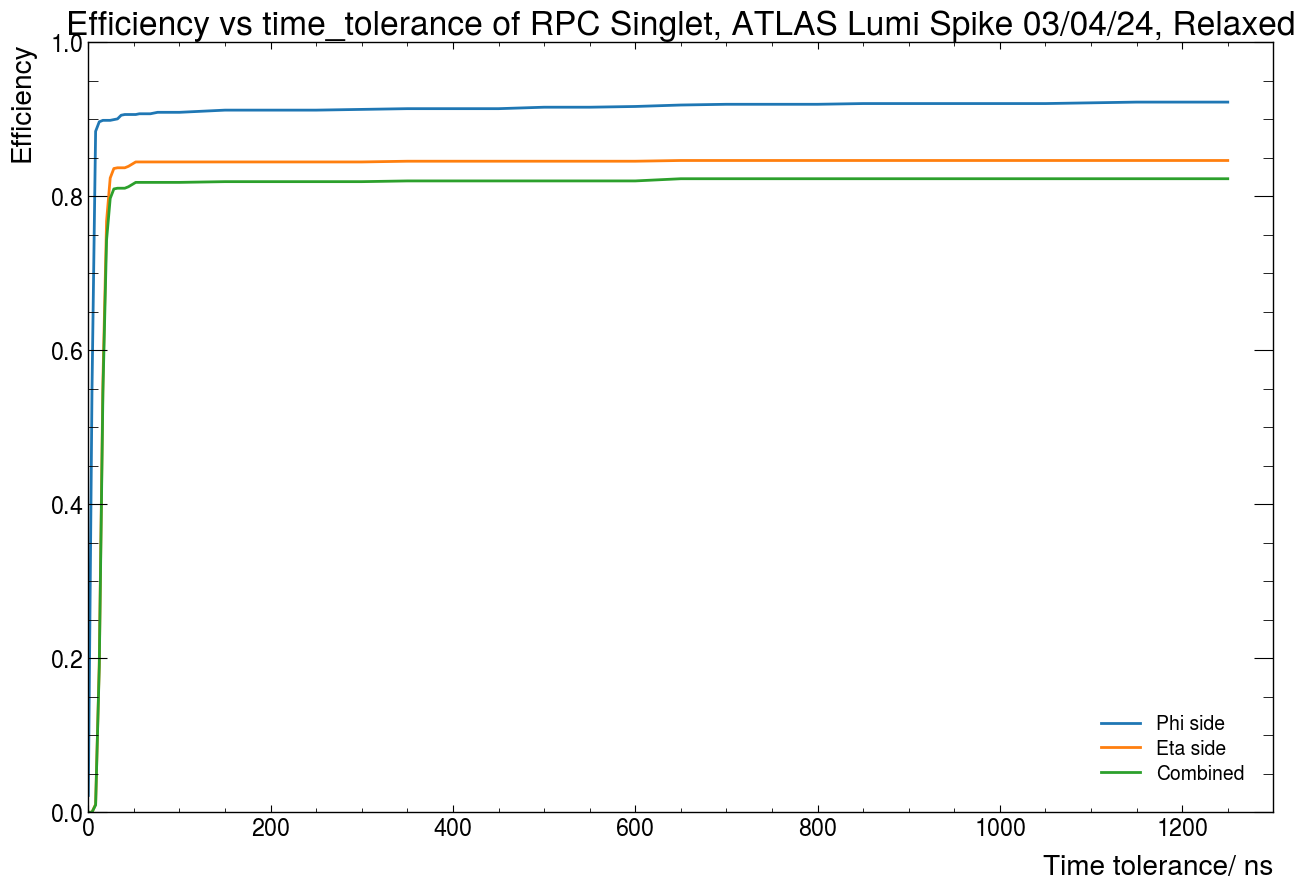

0
1638
1
42
0
4
1638
2
475
1
8
1638
30
1072
26
12
1638
170
1372
157
16
1638
459
1473
432
20
1638
681
1480
649
24
1638
758
1482
723
28
1638
776
1482
740
32
1638
777
1482
741
36
1638
778
1484
742
40
1638
778
1484
742
44
1638
778
1485
742
48
1638
780
1486
744
52
1638
780
1486
744
56
1638
780
1488
744
60
1638
780
1488
744
64
1638
780
1488
744
68
1638
780
1488
744
72
1638
780
1488
744
76
1638
780
1488
744
80
1638
780
1488
744
84
1638
780
1488
744
88
1638
780
1488
744
92
1638
780
1489
744
96
1638
780
1489
744
100
1638
780
1490
744
150
1638
781
1493
744
200
1638
781
1494
744
250
1638
781
1497
744
300
1638
781
1500
745
350
1638
781
1501
745
400
1638
781
1504
746
450
1638
781
1504
746
500
1638
781
1506
747
550
1638
781
1507
748
600
1638
781
1507
748
650
1638
781
1510
748
700
1638
781
1510
748
750
1638
782
1510
748
800
1638
782
1511
748
850
1638
782
1515
750
900
1638
783
1516
750
950
1638
784
1519
752
1000
1638
786
1519
752
1050
1638
786
1520
753
1100
1638
786
1521
754
1150
1638
786
1522
754
120

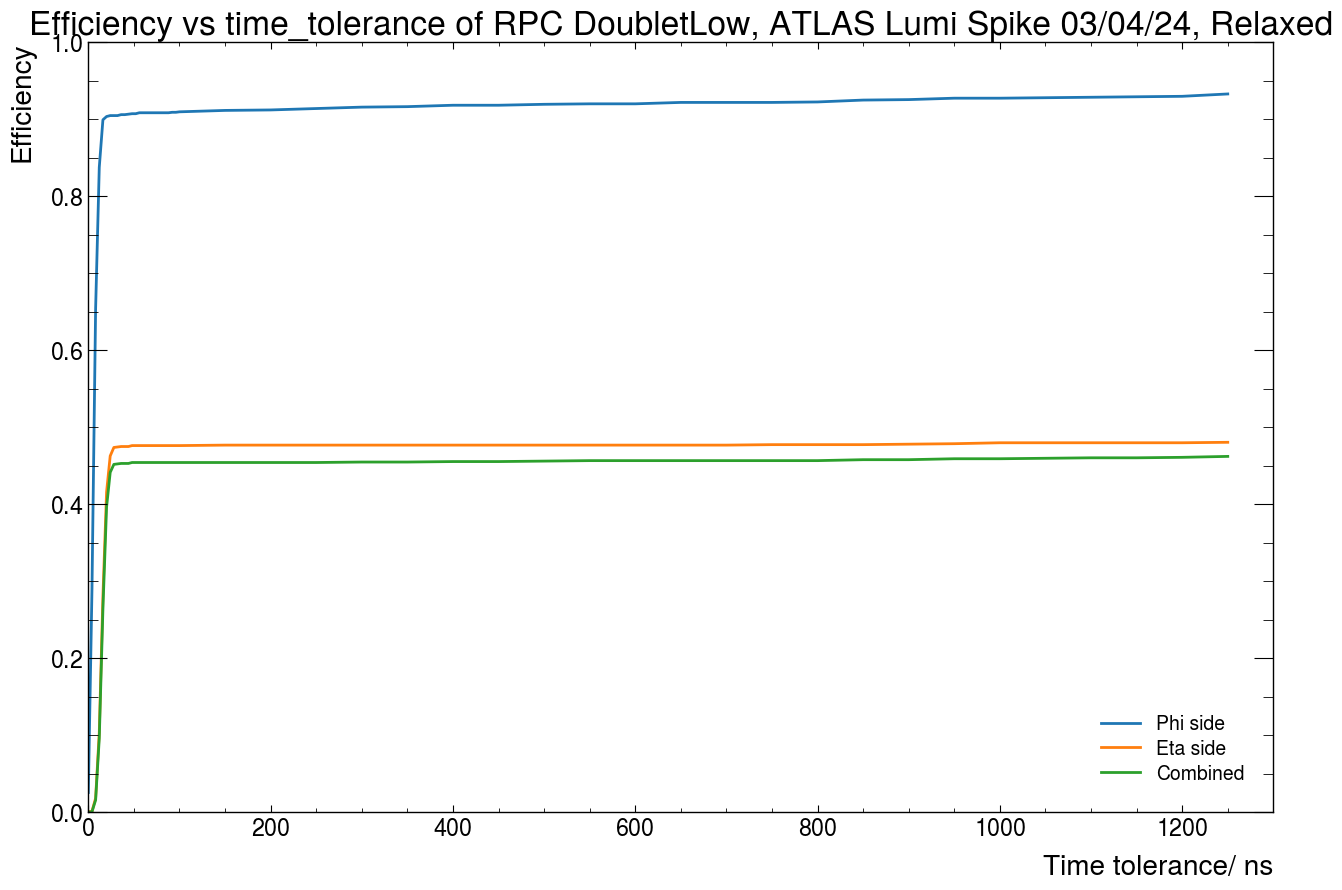

0
1717
1
231
0
4
1717
8
500
4
8
1717
32
764
26
12
1717
191
884
166
16
1717
590
909
459
20
1717
1029
915
707
24
1717
1257
916
788
28
1717
1365
918
811
32
1717
1387
920
815
36
1717
1389
920
815
40
1717
1390
920
815
44
1717
1392
920
815
48
1717
1394
920
817
52
1717
1394
920
817
56
1717
1395
920
817
60
1717
1395
920
817
64
1717
1395
920
817
68
1717
1395
920
817
72
1717
1395
920
817
76
1717
1395
920
817
80
1717
1395
920
817
84
1717
1395
920
817
88
1717
1395
920
817
92
1717
1396
920
817
96
1717
1396
921
818
100
1717
1396
921
818
150
1717
1396
921
818
200
1717
1396
921
818
250
1717
1397
921
818
300
1717
1398
921
818
350
1717
1399
921
818
400
1717
1399
921
818
450
1717
1399
921
818
500
1717
1400
921
818
550
1717
1400
922
819
600
1717
1400
922
819
650
1717
1400
923
819
700
1717
1401
923
819
750
1717
1401
923
819
800
1717
1401
923
819
850
1717
1402
923
819
900
1717
1404
923
819
950
1717
1404
923
819
1000
1717
1404
923
819
1050
1717
1404
923
819
1100
1717
1404
924
820
1150
1717
1404
924
820
1200


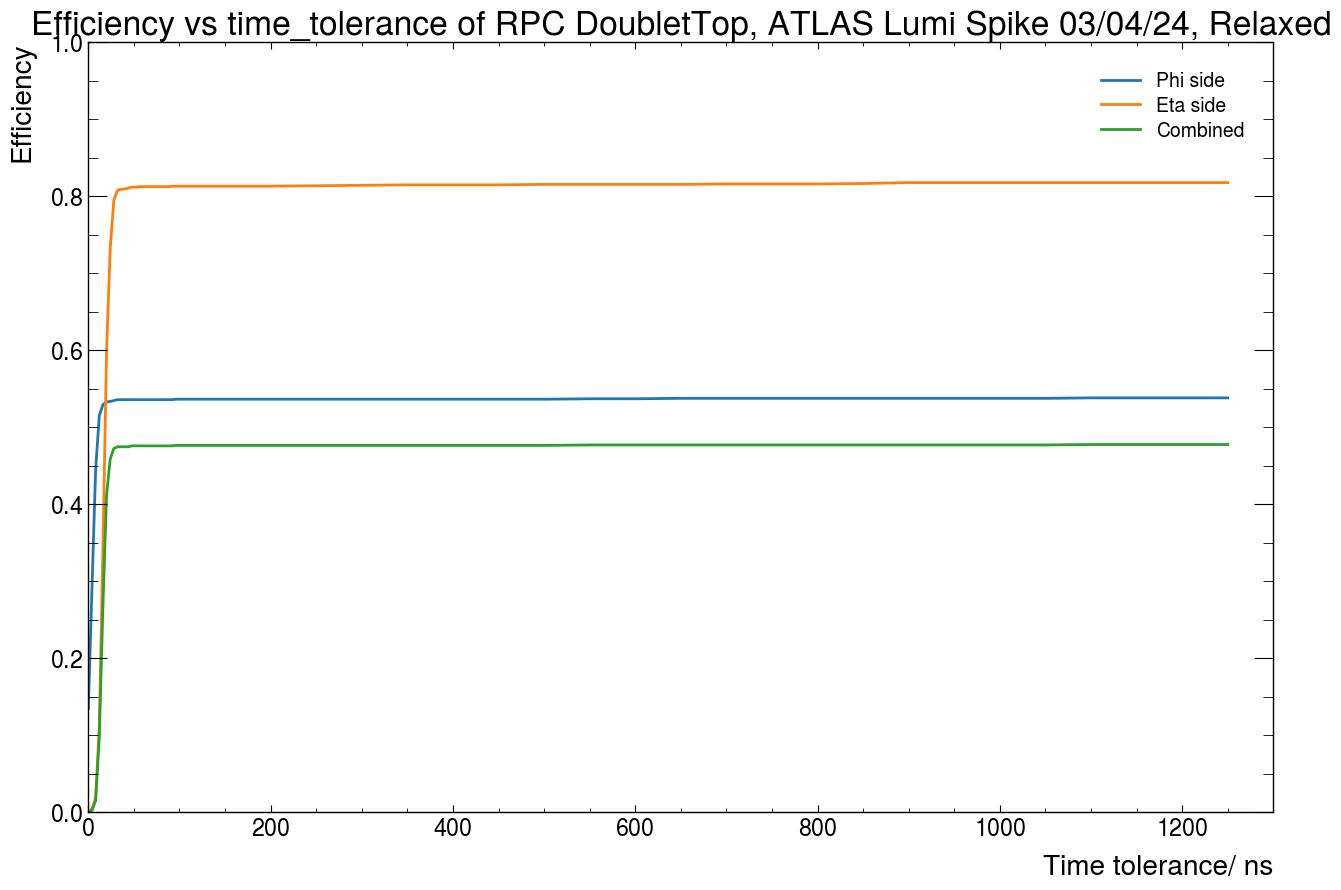

In [88]:
time_tolerances = [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250]

RPCS = ['TripletLow','TripletMid','TripletTop','Singlet','DoubletLow','DoubletTop']

for RPC in range(6):

    #efficiencies_RPC = [Phi,eta,combined]
    efficiencies_RPC = [[],[],[]]

    for time_tol in time_tolerances:
        print(time_tol)

        relaxed_efficiencies = calc_efficiency_RPC_relaxed(coincident_hits_ATLAS_clustered,RPC,phiHits,etaHits,time_tol)

        #phi
        efficiencies_RPC[0].append(relaxed_efficiencies[0])
        #eta
        efficiencies_RPC[1].append(relaxed_efficiencies[1])
        #combined
        efficiencies_RPC[2].append(relaxed_efficiencies[2])
        
    plt.figure(figsize=(15,10))

    plt.plot(time_tolerances, efficiencies_RPC[0],label='Phi side')
    plt.plot(time_tolerances, efficiencies_RPC[1],label='Eta side')
    plt.plot(time_tolerances, efficiencies_RPC[2],label='Combined')

    plt.legend()

    plt.xlim(0,1300)

    plt.xlabel('Time tolerance/ ns')
    plt.ylabel('Efficiency')
    plt.ylim(0,1)

    plt.title(f'Efficiency vs time_tolerance of RPC {RPCS[RPC]}, ATLAS Lumi Spike 03/04/24, Relaxed')

    plt.show()


In [84]:
first = list(np.arange(0,101,4))
second = list(np.arange(150,1251,50))

combined = first+second

In [87]:
print(combined)

[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250]
